# Effect of online product description on its sales

*Authors: Nicolas Gouget, Valentina Jerusalmi, Jonny Preuss, Tom Terrier, Carla Martin*



### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
!pip install stop_words
from stop_words import get_stop_words
stopwords= get_stop_words('french')

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=a095f8f81ae69b13a57392ff659d8eba8a02bd7acc24664c26c752c424583772
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


## Cleaning and Preprocessing

In [2]:
import os
import glob
from google.colab import drive

## load train, test and validation label arrays
drive = drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
path = 'drive/MyDrive/Ensemble_Project/'
df = pd.read_csv(path+'products.csv', encoding="utf-8")
df.head()

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,EUR,100,0,3.76,54,26.0,8.0,10.0,1.0,9.0,0,0,0,0,"Summer,Fashion,womenunderwearsuit,printedpajam...",white,M,50,Livraison standard,4,0,34,50,1.0,Quantité limitée !,CN,zgrdejia,zgrdejia,(568 notes),568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,EUR,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,"Mini,womens dresses,Summer,Patchwork,fashion d...",green,XS,50,Livraison standard,2,0,41,50,1.0,Quantité limitée !,CN,SaraHouse,sarahouse,"83 % avis positifs (17,752 notes)",17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,43,EUR,100,0,3.57,14,5.0,4.0,2.0,0.0,3.0,0,0,0,0,"Summer,cardigan,women beachwear,chiffon,Sexy w...",leopardprint,XS,1,Livraison standard,3,0,36,50,1.0,Quantité limitée !,CN,hxt520,hxt520,86 % avis positifs (295 notes),295,3.989831,5d464a1ffdf7bc44ee933c65,0,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,EUR,5000,1,4.03,579,295.0,119.0,87.0,42.0,36.0,0,0,0,0,"Summer,Shorts,Cotton,Cotton T Shirt,Sleeve,pri...",black,M,50,Livraison standard,2,0,41,50,NaN,NaN,CN,allenfan,allenfan,"(23,832 notes)",23832,4.020435,58cfdefdacb37b556efdff7c,0,NaN,https://www.wish.com/c/5cedf17ad1d44c52c59e4aca,https://contestimg.wish.com/api/webimage/5cedf...,5cedf17ad1d44c52c59e4aca,summer,2020-08
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,EUR,100,1,3.10,20,6.0,4.0,2.0,2.0,6.0,0,0,0,0,"Summer,Plus Size,Lace,Casual pants,Bottom,pant...",yellow,S,1,Livraison standard,1,0,35,50,1.0,Quantité limitée !,CN,youngpeopleshop,happyhorses,"85 % avis positifs (14,482 notes)",14482,4.001588,5ab3b592c3911a095ad5dadb,0,NaN,https://www.wish.com/c/5ebf5819ebac372b070b0e70,https://contestimg.wish.com/api/webimage/5ebf5...,5ebf5819ebac372b070b0e70,summer,2020-08


### Drop useless features
After visual inspection and variance analysis of the features, we removed the ones that do not contain any valuable information

In [4]:
df = df.drop(['merchant_profile_picture', "shipping_option_name", 'product_url', 'product_picture','currency_buyer','merchant_id', 
              "merchant_title",'crawl_month','theme', 'currency_buyer', 'merchant_name','product_id', 'urgency_text'], axis = 1)
df = df.drop_duplicates()

### Identifying word_impact on turnover and units sold


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
df["turnover"] = df["price"]*df["units_sold"]


sc = StandardScaler()
#Scaling turnover
scaled_to = sc.fit_transform(np.array(df["turnover"]).reshape(-1,1))

#TFIDF representation of the descriptions
titles = df["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
tfidf = TfidfVectorizer()
transf_titles = tfidf.fit_transform(titles)
transf_titles = csr_matrix.todense(transf_titles)

#Concatenating TFIDF representations with scaled turnover
transf_titles = np.hstack((transf_titles,scaled_to))

#Computing word impact on the turnover : word impact = word_importance * Scaled_CA
word_impact = np.zeros((1,transf_titles.shape[1]-1))
for i in range(transf_titles.shape[1]-1):
    impact = 0
    for j in range(transf_titles.shape[0]):
        impact += transf_titles[j,i]*transf_titles[j,-1]
    word_impact[0,i] = impact
        
#Computing mean word_impact for each description
cv = CountVectorizer()
cv_titles = cv.fit_transform(titles)
desc_length = np.sum(csr_matrix.todense(cv_titles),axis=1)

desc_impact_to = np.matmul(csr_matrix.todense(cv_titles),word_impact.T)/desc_length

df["desc_impact_to"] = desc_impact_to

In [6]:
sc = StandardScaler()

#Scaling units_sold
scaled_us = sc.fit_transform(np.array(df["units_sold"]).reshape(-1,1))

#TFIDF representation of the descriptions
titles = df["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
tfidf = TfidfVectorizer()
transf_titles = tfidf.fit_transform(titles)
transf_titles = csr_matrix.todense(transf_titles)

#Concatenating TFIDF representations with scaled units_sold
transf_titles = np.hstack((transf_titles,scaled_us))

#Computing word impact on the turnover : word impact = word_importance * Scaled_CA
word_impact = np.zeros((1,transf_titles.shape[1]-1))
for i in range(transf_titles.shape[1]-1):
    impact = 0
    for j in range(transf_titles.shape[0]):
        impact += transf_titles[j,i]*transf_titles[j,-1]
    word_impact[0,i] = impact
    
#Computing mean word_impact for each description
cv = CountVectorizer()
cv_titles = cv.fit_transform(titles)
desc_length = np.sum(csr_matrix.todense(cv_titles),axis=1)

desc_impact_us = np.matmul(csr_matrix.todense(cv_titles),word_impact.T)/desc_length

df["desc_impact_us"] = desc_impact_us

### Male or Female item identification

In [7]:
## taking the titles and putting them into a list

title_list = []

for row in df['title_orig']:
    title_list.append(row.split())


## making a list for checking for gender-revealing words

gender_list = []

for entry in title_list:
    if 'women' in entry:
        gender_list.append('f')
    elif 'Women' in entry:
        gender_list.append('f')
    elif 'Women\'s' in entry:
        gender_list.append('f')
    elif 'men' in entry:
        gender_list.append('m')
    elif 'Men' in entry:
        gender_list.append('m')
    elif 'Men\'s' in entry:
        gender_list.append('m')
    else: gender_list.append('n')


## adding the gender as column

df['gender_in_title'] = gender_list

### Cleaning of special characters

In [8]:
new_list = []

df[df['merchant_info_subtitle'].isnull()] = 'NoRec'

for row in df['merchant_info_subtitle']:
    new_list.append(row.split('%'))

    
new = []
for element in new_list:
    if len(element)==2:
      if(element[0] == "คำติชมเชิงบวก 82"):
        new.append(float(82))
      elif(element[0] == "คำติชมเชิงบวก 83"):
        new.append(float(83))
      else:
        new.append(element[0])
    else: new.append(np.nan)

df['Percentage_Positive'] = new
#print(df['Percentage_Positive'])
df['Percentage_Positive'] = df['Percentage_Positive'].astype("float")
df = df.drop(['merchant_info_subtitle'], axis = 1)
df = df[df != "NoRec"]

### Filling NAs where necessary

In [9]:
df.loc[:,["price", "retail_price", "rating", "merchant_rating", "countries_shipped_to", "shipping_option_price","desc_impact_to","desc_impact_us"]] = df.loc[:,["price", "retail_price", "rating", "merchant_rating", "countries_shipped_to", "shipping_option_price","desc_impact_to","desc_impact_us"]].fillna(0)

df.loc[:,["price", "retail_price", "rating", "merchant_rating", "countries_shipped_to", "shipping_option_price","desc_impact_to","desc_impact_us"]] = df.loc[:,["price", "retail_price", "rating", "merchant_rating", "countries_shipped_to", "shipping_option_price","desc_impact_to","desc_impact_us"]].astype("float")

df[["units_sold", "uses_ad_boosts", "rating_count", "rating_five_count", "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count", \
    "merchant_has_profile_picture", "merchant_rating_count", "has_urgency_banner", "inventory_total", "shipping_is_express", "product_variation_inventory", \
    "badge_fast_shipping", "badge_product_quality", "badge_local_product", "badges_count"]] = df[["units_sold", "uses_ad_boosts", "rating_count", "rating_five_count", "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count", \
    "merchant_has_profile_picture", "merchant_rating_count", "has_urgency_banner", "inventory_total", "shipping_is_express", "product_variation_inventory", \
    "badge_fast_shipping", "badge_product_quality", "badge_local_product", "badges_count"]].fillna(0)
df[["units_sold", "uses_ad_boosts", "rating_count", "rating_five_count", "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count", \
    "merchant_has_profile_picture", "merchant_rating_count", "has_urgency_banner", "inventory_total", "shipping_is_express", "product_variation_inventory", \
    "badge_fast_shipping", "badge_product_quality", "badge_local_product", "badges_count"]] = df[["units_sold", "uses_ad_boosts", "rating_count", "rating_five_count", "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count", \
    "merchant_has_profile_picture", "merchant_rating_count", "has_urgency_banner", "inventory_total", "shipping_is_express", "product_variation_inventory", \
    "badge_fast_shipping", "badge_product_quality", "badge_local_product", "badges_count"]].astype("int")

### Percentage of the Price in comparison to the Market

In [10]:
df["percentage_compared_to_market"] = round((df["price"] \
                                             - df["retail_price"])\
                                            /df["retail_price"] * 100,0)
df = df.drop(["retail_price"], axis = 1)
df.loc[:,["rating_five_count", "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count"]] = df.loc[:,["rating_five_count"\
                                                                                                                               , "rating_four_count", "rating_three_count", "rating_two_count", "rating_one_count"]].fillna(0)

### Cleaning of the product_variation_size_id feature

In [11]:
df['product_variation_size_id'][df['product_variation_size_id'].isin(['S.','s','Suit-S','Size S.','Size S','size S','S(bust 88cm)','S (waist58-62cm)',
                                        'S (waist58-62cm)','S(Pink & Black)','US-S','Size-S','S Diameter 30cm',
                                        'SIZE S','Size--S','SIZE S','pants-S','S..','Size/S','S Pink','25-S'])] = 'S'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['choose a size','4','1m by 3m','Women Size 36','US 6.5 (EU 37)','26(Waist 72cm 28inch)',
                                        '29','1pc','100 cm','1','2pcs','30cm','33','100 x 100cm(39.3 x 39.3inch)',
                                        'NoRec','100 x 100cm(39.3 x 39.3inch)','35','34','20pcs','White',
                                        '25','Round','Pack of 1', '1 pc.', 'AU plug Low quality','2','10 ml','60',
                                        'US5.5-EU35','10pcs','17','Women Size 37','60','US5.5-EU35','3 layered anklet',
                                        'first  generation', '80 X 200 CM', 'EU39(US8)','Base Coat','36','20PCS-10PAIRS',
                                        'B','5','H01','40cm','One Size','Base & Top & Matte Top Coat','40 cm','30 cm',
                                        '5PAIRS','EU 35','100pcs'])] = 'Other'


df['product_variation_size_id'][df['product_variation_size_id'].isin(['S/M(child)','daughter 24M','Baby Float Boat', 'Floating Chair for Kid','4-5 Years',
                                        'daughter 24M'])] = 'Kids'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['XXXXXL','3XL','SIZE-4XL', 'XXXL','5XL',
                                        '2XL','4XL','XXXXL','6XL','Size-5XL','Size4XL','04-3XL',''])] = 'XXXL'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['XS.', 'SIZE-XS', 'Size-XS', 'SIZE XS'])] = 'XS'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['SIZE-XXS','SIZE XXS','Size-XXS','SIZE-XXS','Size -XXS','Size XXS'])] = 'XXS'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['SizeL','L.','Size-L','32/L'])]= 'L'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['1 PC - XL','X   L'])] = 'XL'

df['product_variation_size_id'][df['product_variation_size_id'].isin(['M.','Size M'])] = 'M'

df['product_variation_size_id'][df['product_variation_size_id'].isnull()] = 'Other'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.l

In [12]:
df["product_variation_size_id"].unique() #check

array(['M', 'XS', 'S', 'XXS', 'L', 'XXL', 'Other', 'XXXL', 'XL', 'XXXS',
       'Kids'], dtype=object)

### Generating dummy variables for country, size and gender

In [13]:
df_dummies = pd.get_dummies(df, columns=['origin_country', 'product_variation_size_id', 'gender_in_title'])
df_dummies = df_dummies.drop(["product_variation_size_id_Other"], axis = 1)

### Preprocessing of the color feature

In [14]:
def preprocessing_color(df):
    df_summer = df.copy(deep = True)
    
    df_summer['product_color'] = df_summer['product_color'].replace('black & green', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('black & white', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('black & yellow', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('black & blue', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('black & yellow', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('black & stripe', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('blue & pink', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('brown & yellow', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('pink & blue', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('navyblue & white', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('gray & white', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('orange & camouflage', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('red & blue', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('pink & black', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('pink & grey', 'Multi')    
    df_summer['product_color'] = df_summer['product_color'].replace('pink & white', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('white & black', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('blackwhite', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('white & red', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('white & green', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('winered & yellow', 'Multi')
    df_summer['product_color'] = df_summer['product_color'].replace('multicolor', 'Multi')
    

    df_summer['product_color'] = df_summer['product_color'].replace('winered', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('red', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('rosered', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('orange-red', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('RED', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('lightred', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('wine red', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('coralred', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('watermelonred', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('Rose red', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('burgundy', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('claret', 'Red')
    df_summer['product_color'] = df_summer['product_color'].replace('wine', 'Red')
    
    
    df_summer['product_color'] = df_summer['product_color'].replace('white', 'White')
    df_summer['product_color'] = df_summer['product_color'].replace('offwhite', 'White')
    df_summer['product_color'] = df_summer['product_color'].replace('whitefloral', 'White')
    df_summer['product_color'] = df_summer['product_color'].replace('whitestripe', 'White')
    df_summer['product_color'] = df_summer['product_color'].replace('ivory', 'White')
    
    
    df_summer['product_color'] = df_summer['product_color'].replace('black', 'Black')
    df_summer['product_color'] = df_summer['product_color'].replace('coolblack', 'Black')
    df_summer['product_color'] = df_summer['product_color'].replace('offblack', 'Black')

    
    df_summer['product_color'] = df_summer['product_color'].replace('rose', 'Pink')
    df_summer['product_color'] = df_summer['product_color'].replace('lightpink', 'Pink')
    df_summer['product_color'] = df_summer['product_color'].replace('pink', 'Pink')
    df_summer['product_color'] = df_summer['product_color'].replace('dustypink', 'Pink')

    
    df_summer['product_color'] = df_summer['product_color'].replace('armygreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('green', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('khaki', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('lightgreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('fluorescentgreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('Army green', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('mintgreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('light green', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('applegreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('army green', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('darkgreen', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('lightkhaki', 'Green')
    df_summer['product_color'] = df_summer['product_color'].replace('army', 'Green')


    df_summer['product_color'] = df_summer['product_color'].replace('navyblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('lightblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('skyblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('darkblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('navy', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('blue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('navy blue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('lakeblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('denimblue', 'Blue')
    df_summer['product_color'] = df_summer['product_color'].replace('prussianblue', 'Blue')

    df_summer['product_color'] = df_summer['product_color'].replace('beige', 'Beige')

    df_summer['product_color'] = df_summer['product_color'].replace('gray', 'Grey')
    df_summer['product_color'] = df_summer['product_color'].replace('grey', 'Grey')
    df_summer['product_color'] = df_summer['product_color'].replace('lightgrey', 'Grey')
    df_summer['product_color'] = df_summer['product_color'].replace('lightgray', 'Grey')
    
    df_summer['product_color'] = df_summer['product_color'].replace('purple', 'Purple')
    df_summer['product_color'] = df_summer['product_color'].replace('violet', 'Purple')
    df_summer['product_color'] = df_summer['product_color'].replace('lightpurple', 'Purple')

    df_summer['product_color'] = df_summer['product_color'].replace('coffee', 'Brown')
    df_summer['product_color'] = df_summer['product_color'].replace('brown', 'Brown')

    
    df_summer['product_color'] = df_summer['product_color'].replace('floral', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('leopard', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('camouflage', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('leopardprint', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('greysnakeskinprint', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('silver', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('camel', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('jasper', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('rosegold', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('gold', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('star', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('tan', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('rainbow', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace('nude', 'Other')
    df_summer['product_color'] = df_summer['product_color'].replace(np.nan, 'Other')
    
    df_summer['product_color'] = df_summer['product_color'].replace('orange', 'Orange')
    df_summer['product_color'] = df_summer['product_color'].replace('apricot', 'Orange')
    
    df_summer['product_color'] = df_summer['product_color'].replace('yellow', 'Yellow')
    df_summer['product_color'] = df_summer['product_color'].replace('lightyellow', 'Yellow')

    return df_summer

df_dummies_colors = preprocessing_color(df_dummies)
#print(np.sum(df_dummies_colors == df_dummies))

df_dummies_colors = pd.get_dummies(df_dummies_colors, columns=["product_color"])
df_dummies_Colors = df_dummies_colors.drop(["product_color_Other"], axis = 1)
print(len(df_dummies_colors.columns))

63


In [15]:
df = df_dummies_colors

### Tags Percentages

In [16]:
## check if there are any nulls before calculating percentages and then filling them


#print(df['tags'].isnull().sum())
df['tags'] = df.reindex(columns = ['tags']).fillna('no_tag')

## percentage of tags a product has of total tags

tags_percentages = []
number_of_tags = 2620

for row in df['tags']:
    new = row.split(',')
    tag_percentage = round((len(new)/number_of_tags)*100,4)
    #print(new)
    #print(tag_percentage)
    tags_percentages.append(tag_percentage)

## adding the tag_percentage column

df['tag_percentage'] = tags_percentages

### Further Drops 

In [17]:
df = df.drop(["title","title_orig","turnover","tags"],axis=1)

### Drop some of the classes

We have classes with only one record. This is making the classification problem way more complicated.
In order to fix this big bias, we will remove the classes with less than 5 records. This is a small trade-off that we are willing to accept in order to gain accuracy on the rest of the classes.

In [18]:
df['units_sold'].value_counts()

100       492
1000      403
5000      216
10000     176
20000     103
50         68
10         44
50000      17
100000      6
8           3
1           3
7           2
3           2
2           2
6           1
0           1
Name: units_sold, dtype: int64

In [19]:
df = df[df['units_sold']!=7]
df = df[df['units_sold']!=2]
df = df[df['units_sold']!=0]
df = df[df['units_sold']!=3]
df = df[df['units_sold']!=1]
df = df[df['units_sold']!=8]
df = df[df['units_sold']!=6]

## Splitting into Training and Test set

In [20]:
X = df.loc[:, df.columns != 'units_sold'] #features
y = df[['units_sold']] #target variable

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Classification Task

### Stacking Classifier


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier

# Classifiers
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy

# Used to ignore warnings generated from StackingCVClassifier
import warnings
warnings.simplefilter('ignore')

df['Percentage_Positive'] = df['Percentage_Positive'].fillna(df['Percentage_Positive'].mean())

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initializing Support Vector classifier
classifier1 = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
classifier2 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
classifier3 = AdaBoostClassifier(n_estimators=200, learning_rate=0.5)

# Initializing Random Forest classifier
classifier4 = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

# Initializing the StackingCV classifier
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = SVC(probability = True))

# Create list to store classifiers
classifiers = {"SVC": classifier1,
               "MLP": classifier2,
               "ADABOOST": classifier3,
               "RF": classifier4,
               "Stack": sclf}

# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    print(classifier)
    
    # Fit classifier
    classifier.fit(X_train, np.ravel(y_train))
        
    # Save fitted classifier
    classifiers[key] = classifier

for key in classifiers:
    print(key, ":",classifiers[key].score(X_test, y_test, sample_weight=None))

### Simple XGBoost

For the XGBoost task we want to take into account the class imbalance. For this reason we wanted to use the *sample_weight* feature available in XGBClassifier(). In order to do this, we generate an array of weights as follows.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
y_train.value_counts()
ordered_classes = [100,1000,5000,10000,20000,50,10,50000,100000]

In [ ]:
tot_sum = sum(y_train.value_counts())
weights = y_train.value_counts()/tot_sum

w = {}
for idx,weight in enumerate(weights):
    w[ordered_classes[idx]] = weight

w_array = np.ones(len(y_train), dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = w[y_train['units_sold'][i]]

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,np.ravel(y_train), sample_weight = w_array)
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_test,np.ravel(y_pred))
print("Accuracy: %.2f%%" % (acc *100.0))

Accuracy: 77.75%


In [ ]:
clf = XGBClassifier(max_depth=10, objective='multi:softprob', n_estimators=2000, gamma=0.8)

clf.fit(X_train, np.ravel(y_train))

# evaluate predictions
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, np.ravel(y_pred))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.53%


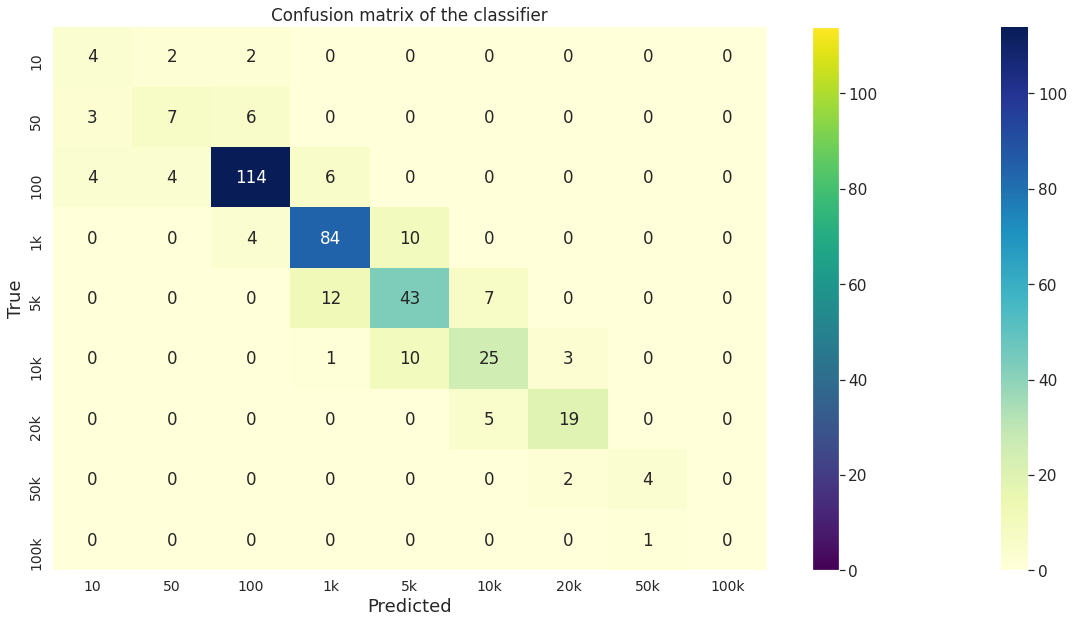

In [ ]:
import seaborn as sns

lab = ['10','50','100', '1k', '5k', '10k', '20k','50k','100k']
from sklearn.metrics import confusion_matrix
sns.set(font_scale=1.4)
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap="YlGnBu")
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(lab,fontsize = 14)
ax.set_yticklabels(lab,fontsize = 14)
plt.xlabel('Predicted',fontsize = 18)
plt.ylabel('True',fontsize = 18)
plt.show()

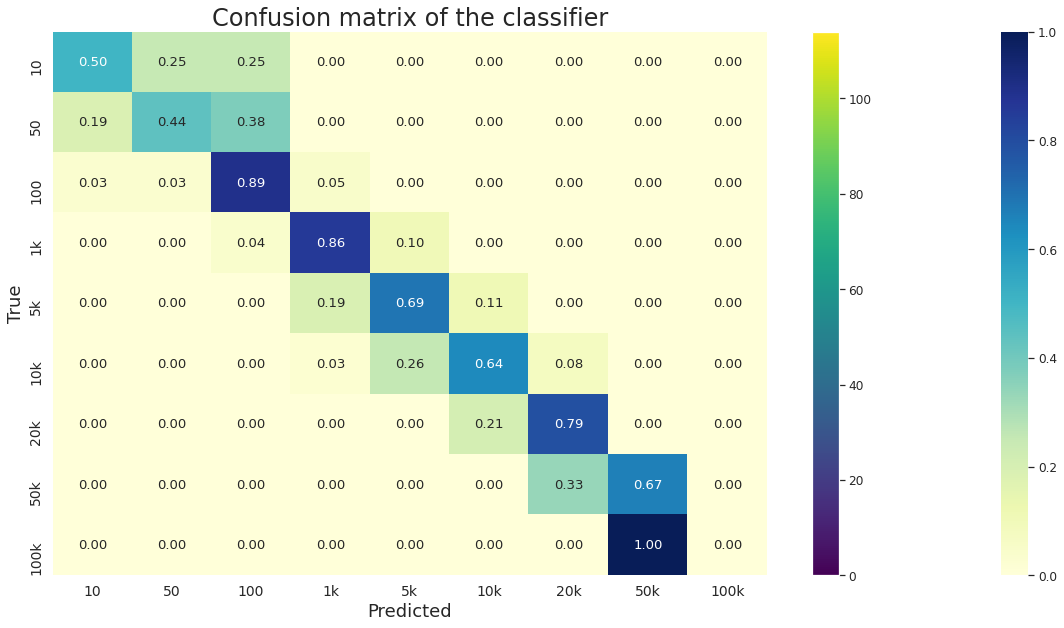

In [ ]:
lab = ['10','50','100', '1k', '5k', '10k', '20k','50k','100k']
from sklearn.metrics import confusion_matrix
sns.set(font_scale=1.1)
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
sns.heatmap(cmn, annot=True, ax = ax,fmt='.2f',cmap="YlGnBu")
plt.title('Confusion matrix of the classifier', fontsize=24)
fig.colorbar(cax)
ax.set_xticklabels(lab,fontsize = 14)
ax.set_yticklabels(lab,fontsize = 14)
plt.xlabel('Predicted',fontsize = 18)
plt.ylabel('True',fontsize = 18)
plt.show()

In order to have a robust method, however, we can't rely only on the performance on the test set. It would be more precise to use cross validation to use the best model that could better generalize on unseen data.
For this reason, in the next section, we will run a grid-search with 3 fold cross-validation in order to find the parameters that best allow XGBoost to be a robust and accurate model.

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

parameters = {'n_estimators': [500],
              'gamma':[0.3,0.7,1],
              'objective':['multi:softprob'],
              'learning_rate': [0.01,0.05], #so called 'eta' value
              'max_depth': [8,16,24],
              'subsample': [0.5,0.9],
              'colsample_bytree': [0.7,1],
              'seed': [42]}


clf = GridSearchCV(xgb, parameters, 
                   cv=3, 
                   scoring='accuracy',
                   verbose=3)

#clf.fit(X, np.ravel(y))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5, score=0.774, total=  10.9s
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5, score=0.764, total=  11.1s
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.0s remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.5, score=0.726, total=  10.9s
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.9, score=0.768, total=  12.0s
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.9, score=0.766, total=  12.2s
[CV] colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimators=500, objective=multi:softprob, seed=42, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0.3, learning_rate=0.01, max_depth=8, n_estimato

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 52.3min finished


AttributeError: ignored

In [ ]:
#trust your CV!
best_parameters = clf.best_params_
print("CROSS VALIDATION RESULTS")
print("Best parameters: ", best_parameters)
print("Best accuracy score:", round(clf.best_score_*100,2),"%")

CROSS VALIDATION RESULTS
Best parameters:  {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 24, 'n_estimators': 500, 'objective': 'multi:softprob', 'seed': 42, 'subsample': 0.5}
Best accuracy score: 75.87 %


#### Improvement check

In [ ]:
parameters = {'n_estimators': [1000],
              'gamma':[0.7,0.8],
              'objective':['multi:softprob'],
              'learning_rate': [0.03,0.05], #so called 'eta' value
              'max_depth': [24],
              'subsample': [0.5,0.7],
              'colsample_bytree': [0.7,0.9],
              'seed': [42]}


clf = GridSearchCV(xgb, parameters, 
                   cv=3, 
                   scoring='accuracy',
                   verbose=3)

#clf.fit(X, np.ravel(y))

best_parameters = clf.best_params_
print("CROSS VALIDATION RESULTS")
print("Best parameters: ", best_parameters)
print("Best accuracy score:", round(clf.best_score_*100,2),"%")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5, score=0.774, total=  23.6s
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5, score=0.764, total=  23.7s
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.3s remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.5, score=0.726, total=  23.0s
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.7, score=0.776, total=  26.6s
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.7, score=0.758, total=  27.0s
[CV] colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=24, n_estimators=1000, objective=multi:softprob, seed=42, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=0.7, learning_rate=0.03, max_depth=2

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 22.0min finished


CROSS VALIDATION RESULTS
Best parameters:  {'colsample_bytree': 0.7, 'gamma': 0.8, 'learning_rate': 0.03, 'max_depth': 24, 'n_estimators': 1000, 'objective': 'multi:softprob', 'seed': 42, 'subsample': 0.5}
Best accuracy score: 75.87 %


### LightGBM 

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train,np.ravel(y_train))
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, np.ravel(y_pred))
print("Accuracy for LGBM:",round(accuracy*100,2),"%")

Accuracy for LGBM: 76.44 %


### Random Forest

In [ ]:
X = df.drop(["Percentage_Positive"], axis = 1).loc[:, df.drop(["Percentage_Positive"], axis = 1).columns != 'units_sold']
X["percentage_compared_to_market"] = X["percentage_compared_to_market"].fillna(0)
y = df[['units_sold']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test, sample_weight=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.7774869109947644

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

accuracy_train = accuracy_score(y_train, np.ravel(y_train_pred))
f1_train = f1_score(y_train, y_train_pred.ravel(), average = "weighted")

print("Training Accuracy: {}% ".format(accuracy_train * 100))
print("Training F1-Score: {} ".format(f1_train))

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Testing Accuracy: {}% ".format(accuracy * 100))
print("Testing F1-Score: {} ".format(f1))

Training Accuracy: 100.0% 
Training F1-Score: 1.0 
Testing Accuracy: 77.74869109947645% 
Testing F1-Score: 0.7727829752861106 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


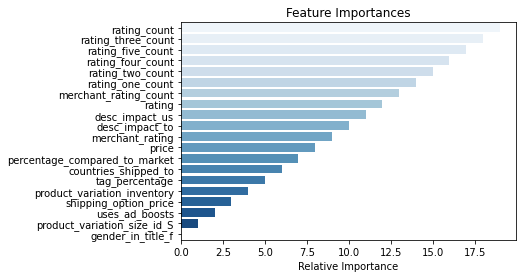

In [ ]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.title('Feature Importances')
sns.barplot(np.array(range(len(indices))), y = np.array(importances[indices]), orient = "h", palette="Blues")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Random Forest with oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy= 'not majority', random_state=101, k_neighbors=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

clf_smote = RandomForestClassifier()
clf_smote.fit(X_train_smote, np.array(y_train_smote).ravel())

In [ ]:
y_train_pred = clf_smote.predict(X_train_smote)
y_pred = clf_smote.predict(X_test)

accuracy_train = accuracy_score(y_train_smote, np.ravel(y_train_pred))
f1_train = f1_score(y_train_smote, y_train_pred.ravel(), average = "weighted")

print("Training Accuracy: {}% ".format(accuracy_train * 100))
print("Training F1-Score: {} ".format(f1_train))

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Testing Accuracy: {}% ".format(accuracy * 100))
print("Testing F1-Score: {} ".format(f1))

Training Accuracy: 100.0% 
Training F1-Score: 1.0 
Testing Accuracy: 76.17801047120419% 
Testing F1-Score: 0.7645003199865252 


### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5) #To remove
gbc.fit(X_train,y_train)

y_pred = gbc.predict(X_test)
y_train_pred = gbc.predict(X_train)

accuracy_train = accuracy_score(y_train, np.ravel(y_train_pred))
f1_train = f1_score(y_train, y_train_pred.ravel(), average = "weighted")

print("Training Accuracy: {}% ".format(accuracy_train * 100))
print("Training F1-Score: {} ".format(f1_train))

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Testing Accuracy: {}% ".format(accuracy * 100))
print("Testing F1-Score: {} ".format(f1))


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 99.65004374453194% 
Training F1-Score: 0.9965828638968834 
Testing Accuracy: 75.39267015706807% 
Testing F1-Score: 0.7572640253828429 


### Filling NULL values for the models that require it

In [22]:
df['Percentage_Positive'] = df['Percentage_Positive'].fillna(df['Percentage_Positive'].mean())

In [23]:
X = df.loc[:, df.columns != 'units_sold'] #features
y = df[['units_sold']] #target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Accuracy: {}% ".format(np.round(accuracy, 2) * 100))
print("F1-Score: {} ".format(np.round(f1, 2)))

pgrid = {"max_depth": [3, 5, 8, 10, 15],
      "min_samples_split": [3, 5, 10, 15, 20],
      "min_samples_leaf": [0.5, 3, 10, 20]}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=pgrid, scoring='accuracy', cv=3)
grid_search.fit(X, y)
print(grid_search.best_estimator_.score(X_test, y_test))
print(grid_search.best_estimator_)

clf_best = grid_search.best_estimator_

y_pred = clf_best.predict(X_test)

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Accuracy: {}% ".format(np.round(accuracy, 2) * 100))
print("F1-Score: {} ".format(np.round(f1, 2)))

Accuracy: 75.0% 
F1-Score: 0.75 
0.7696335078534031
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Accuracy: 77.0% 
F1-Score: 0.77 


In [ ]:
ada = AdaBoostClassifier(clf_best, n_estimators=200, learning_rate=0.5, random_state=42)

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
y_train_pred = ada.predict(X_train)

accuracy_train = accuracy_score(y_train, np.ravel(y_train_pred))
f1_train = f1_score(y_train, y_train_pred.ravel(), average = "weighted")

print("Training Accuracy: {}% ".format(accuracy_train * 100))
print("Training F1-Score: {} ".format(f1_train))

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Testing Accuracy: {}% ".format(accuracy * 100))
print("Testing F1-Score: {} ".format(f1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 98.16272965879264% 
Training F1-Score: 0.9815775242305664 
Testing Accuracy: 78.01047120418848% 
Testing F1-Score: 0.7687547344248784 


###Extra Trees
 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

accuracy_train = accuracy_score(y_train, np.ravel(y_train_pred))
f1_train = f1_score(y_train, y_train_pred.ravel(), average = "weighted")

print("Training Accuracy: {}% ".format(accuracy_train * 100))
print("Training F1-Score: {} ".format(f1_train))

accuracy = accuracy_score(y_test, np.ravel(y_pred))
f1 = f1_score(y_test, y_pred.ravel(), average = "weighted")

print("Testing Accuracy: {}% ".format(accuracy * 100))
print("Testing F1-Score: {} ".format(f1))

Training Accuracy: 100.0% 
Training F1-Score: 1.0 
Testing Accuracy: 78.01047120418848% 
Testing F1-Score: 0.7751100251625181 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Decision Trees

In [26]:
## Applying decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dt = tree.DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [29]:
from sklearn.metrics import accuracy_score

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print(accuracy_score(y_test, y_pred_test))

0.7539267015706806


In [ ]:
## textual representation of the decision tree
#text_representation = tree.export_text(dt)
#print(text_representation)

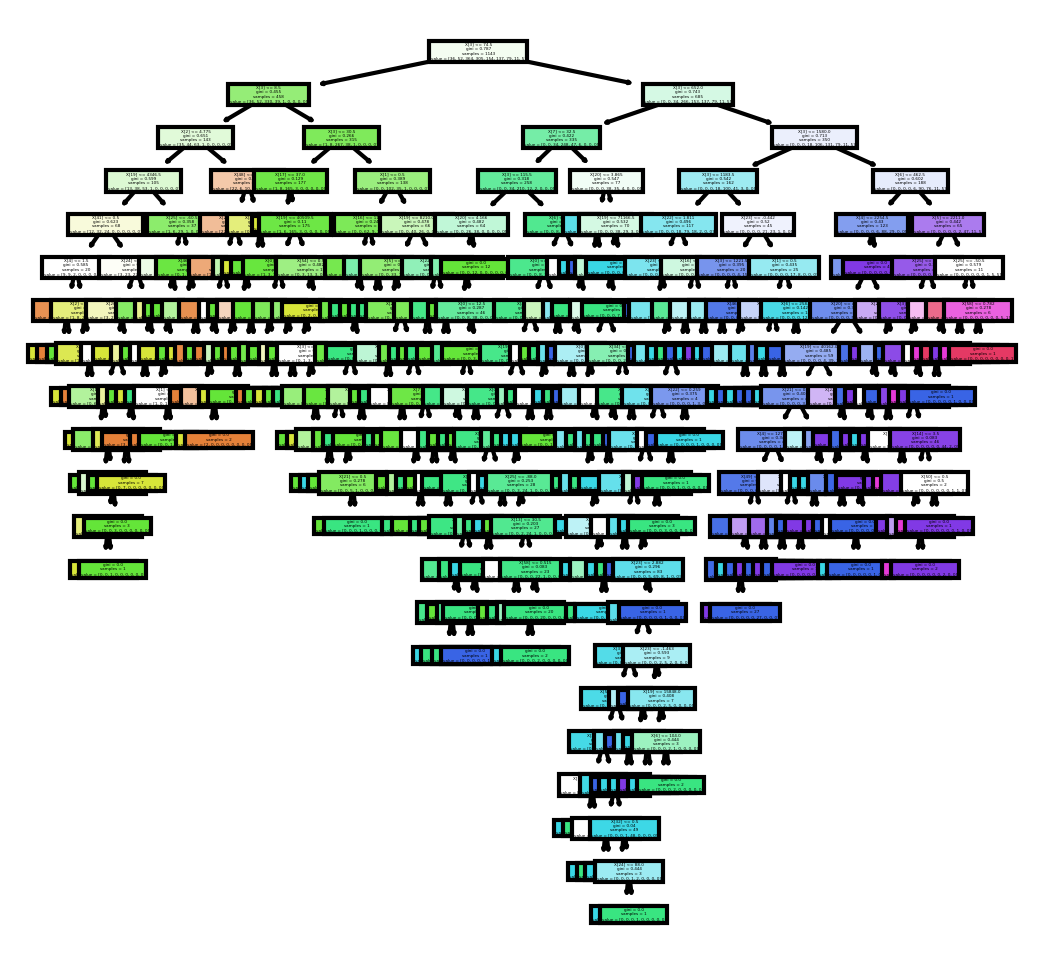

In [ ]:
## visualising the decision tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt, filled = True);

#### "Pruning" with max_depth variations

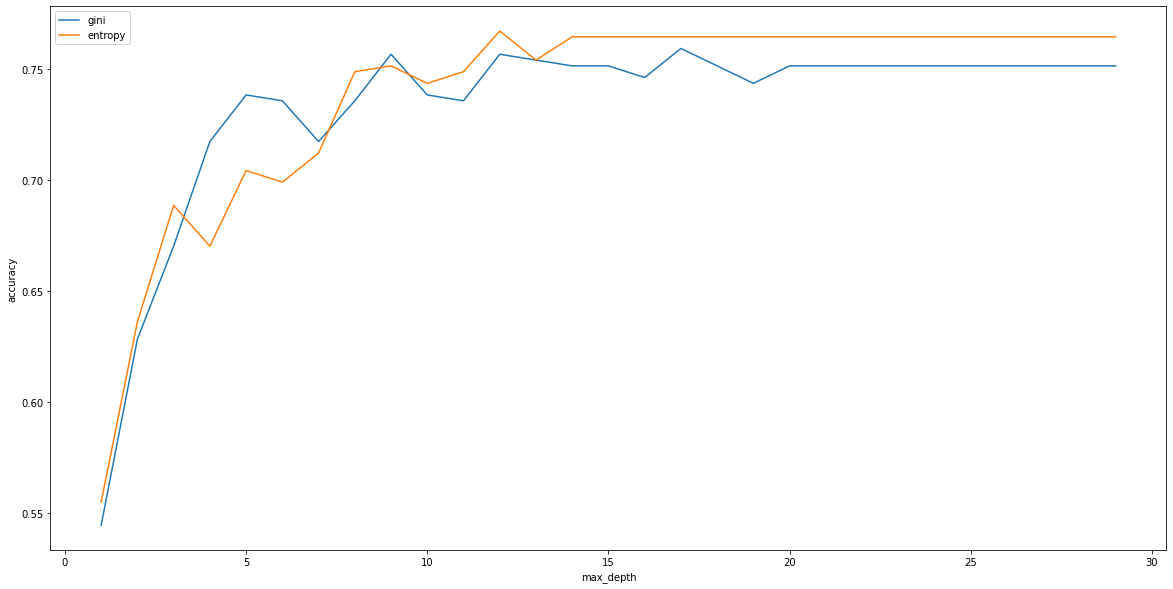

In [ ]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=42)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    
    ####
    
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=42)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    
    ####
    
    max_depth.append(i)

    
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})


# visualizing changes in parameters
plt.figure(figsize=(20,10))
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
dt = DecisionTreeClassifier(random_state=42, max_depth=12,criterion='entropy')
dt.fit(X_train, y_train)
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9851268591426072
0.7670157068062827


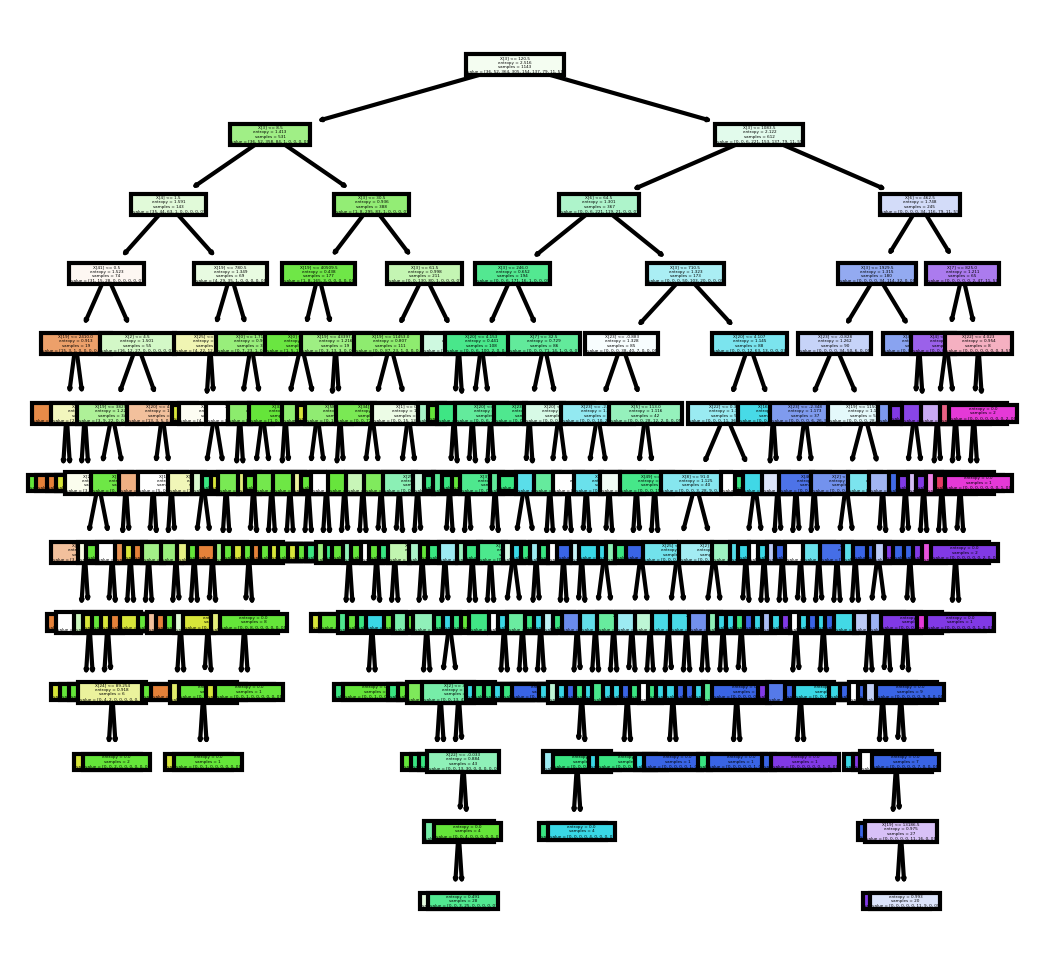

In [ ]:
## visualising the shorter decision tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt, filled = True);

#### Actual pruning

In [ ]:
path=DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

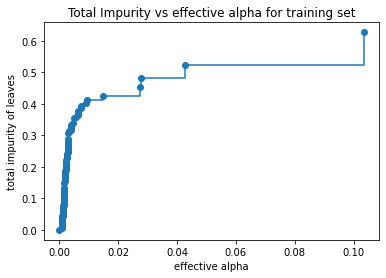

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [ ]:
print("Number of nodes in the last tree is: {} with ccp_alpha: {} and a depth of: {}".format(
clfs[-1].tree_.node_count, ccp_alphas[-1],clfs[-1].tree_.max_depth))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.15935704013003382 and a depth of: 0


In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

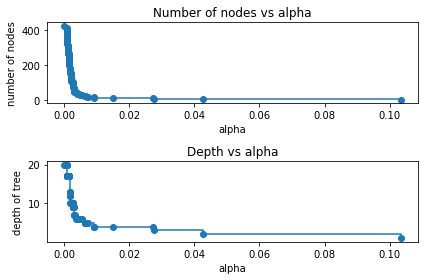

In [ ]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

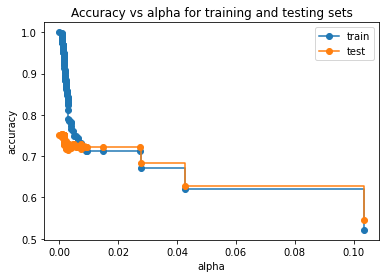

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

Training accuracy of best model:  0.9860017497812773
Test accuracy of best model:  0.7539267015706806


#### GridSearch on DT

In [ ]:
## hyperparameter tuning for decision tree

from sklearn.model_selection import GridSearchCV

max_depth_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
min_samples_leaf_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
min_samples_split_range = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,32,33,34,35,36,37,38,39,40]
max_features_range = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
min_impurity_split_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
min_impurity_decrease_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

tree_param = [{'criterion': ['entropy', 'gini'], 'max_depth': max_depth_range},
              {'max_features': max_features_range, \
               'min_impurity_split': min_impurity_split_range},
              #'min_impurity_decrease': min_impurity_decrease_range},
             {'min_samples_split': min_samples_split_range, 'min_samples_leaf': min_samples_leaf_range}]

dt = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param, cv=3, scoring = 'accuracy',verbose = 3)
dt.fit(X, y)

Fitting 3 folds for each of 749 candidates, totalling 2247 fits
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.619, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.622, total=   0.0s
[CV] criterion=entropy, max_depth=2 ..................................
[CV] ...... criterion=entropy, max_depth=2, score=0.593, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] ...... criterion=entropy, max_depth=3, score=0.695, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] ...... criterion=entropy, max_depth=3, score=0.618, total=   0.0s
[CV] criterion=entropy, max_depth=3 ..................................
[CV] ...... criterion=entropy, max_depth=3, score=0.626, total=   0.0s
[CV] criterion=entropy, max_depth=4 ..................................
[CV] ...... c

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... criterion=entropy, max_depth=5, score=0.677, total=   0.0s
[CV] criterion=entropy, max_depth=5 ..................................
[CV] ...... criterion=entropy, max_depth=5, score=0.665, total=   0.0s
[CV] criterion=entropy, max_depth=6 ..................................
[CV] ...... criterion=entropy, max_depth=6, score=0.715, total=   0.0s
[CV] criterion=entropy, max_depth=6 ..................................
[CV] ...... criterion=entropy, max_depth=6, score=0.691, total=   0.0s
[CV] criterion=entropy, max_depth=6 ..................................
[CV] ...... criterion=entropy, max_depth=6, score=0.630, total=   0.0s
[CV] criterion=entropy, max_depth=7 ..................................
[CV] ...... criterion=entropy, max_depth=7, score=0.688, total=   0.0s
[CV] criterion=entropy, max_depth=7 ..................................
[CV] ...... criterion=entropy, max_depth=7, score=0.705, total=   0.0s
[CV] criterion=entropy, max_depth=7 ..................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=5, min_impurity_split=0.4, score=0.654, total=   0.0s
[CV] max_features=5, min_impurity_split=0.4 ..........................
[CV]  max_features=5, min_impurity_split=0.4, score=0.654, total=   0.0s
[CV] max_features=5, min_impurity_split=0.4 ..........................
[CV]  max_features=5, min_impurity_split=0.4, score=0.657, total=   0.0s
[CV] max_features=5, min_impurity_split=0.5 ..........................
[CV]  max_features=5, min_impurity_split=0.5, score=0.705, total=   0.0s
[CV] max_features=5, min_impurity_split=0.5 ..........................
[CV]  max_features=5, min_impurity_split=0.5, score=0.665, total=   0.0s
[CV] max_features=5, min_impurity_split=0.5 ..........................
[CV]  max_features=5, min_impurity_split=0.5, score=0.654, total=   0.0s
[CV] max_features=5, min_impurity_split=0.6 ..........................
[CV]  max_features=5, min_impurity_split=0.6, score=0.686, total=   0.0s
[CV] max_features=5, min_impurity_split=0.6 ...................

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=10, min_impurity_split=0.2, score=0.681, total=   0.0s
[CV] max_features=10, min_impurity_split=0.3 .........................
[CV]  max_features=10, min_impurity_split=0.3, score=0.711, total=   0.0s
[CV] max_features=10, min_impurity_split=0.3 .........................
[CV]  max_features=10, min_impurity_split=0.3, score=0.715, total=   0.0s
[CV] max_features=10, min_impurity_split=0.3 .........................
[CV]  max_features=10, min_impurity_split=0.3, score=0.665, total=   0.0s
[CV] max_features=10, min_impurity_split=0.4 .........................
[CV]  max_features=10, min_impurity_split=0.4, score=0.640, total=   0.0s
[CV] max_features=10, min_impurity_split=0.4 .........................
[CV]  max_features=10, min_impurity_split=0.4, score=0.732, total=   0.0s
[CV] max_features=10, min_impurity_split=0.4 .........................
[CV]  max_features=10, min_impurity_split=0.4, score=0.642, total=   0.0s
[CV] max_features=10, min_impurity_split=0.5 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=15, min_impurity_split=0.1, score=0.717, total=   0.0s
[CV] max_features=15, min_impurity_split=0.1 .........................
[CV]  max_features=15, min_impurity_split=0.1, score=0.695, total=   0.0s
[CV] max_features=15, min_impurity_split=0.2 .........................
[CV]  max_features=15, min_impurity_split=0.2, score=0.692, total=   0.0s
[CV] max_features=15, min_impurity_split=0.2 .........................
[CV]  max_features=15, min_impurity_split=0.2, score=0.699, total=   0.0s
[CV] max_features=15, min_impurity_split=0.2 .........................
[CV]  max_features=15, min_impurity_split=0.2, score=0.697, total=   0.0s
[CV] max_features=15, min_impurity_split=0.3 .........................
[CV]  max_features=15, min_impurity_split=0.3, score=0.682, total=   0.0s
[CV] max_features=15, min_impurity_split=0.3 .........................
[CV]  max_features=15, min_impurity_split=0.3, score=0.713, total=   0.0s
[CV] max_features=15, min_impurity_split=0.3 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=15, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=15, min_impurity_split=0.9 .........................
[CV]  max_features=15, min_impurity_split=0.9, score=0.322, total=   0.0s
[CV] max_features=15, min_impurity_split=0.9 .........................
[CV]  max_features=15, min_impurity_split=0.9, score=0.323, total=   0.0s
[CV] max_features=15, min_impurity_split=0.9 .........................
[CV]  max_features=15, min_impurity_split=0.9, score=0.323, total=   0.0s
[CV] max_features=20, min_impurity_split=0.1 .........................
[CV]  max_features=20, min_impurity_split=0.1, score=0.688, total=   0.0s
[CV] max_features=20, min_impurity_split=0.1 .........................
[CV]  max_features=20, min_impurity_split=0.1, score=0.675, total=   0.0s
[CV] max_features=20, min_impurity_split=0.1 .........................
[CV]  max_features=20, min_impurity_split=0.1, score=0.659, total=   0.0s
[CV] max_features=20, min_impurity_split=0.2 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=20, min_impurity_split=0.6, score=0.657, total=   0.0s
[CV] max_features=20, min_impurity_split=0.6 .........................
[CV]  max_features=20, min_impurity_split=0.6, score=0.677, total=   0.0s
[CV] max_features=20, min_impurity_split=0.7 .........................
[CV]  max_features=20, min_impurity_split=0.7, score=0.658, total=   0.0s
[CV] max_features=20, min_impurity_split=0.7 .........................
[CV]  max_features=20, min_impurity_split=0.7, score=0.622, total=   0.0s
[CV] max_features=20, min_impurity_split=0.7 .........................
[CV]  max_features=20, min_impurity_split=0.7, score=0.640, total=   0.0s
[CV] max_features=20, min_impurity_split=0.8 .........................
[CV]  max_features=20, min_impurity_split=0.8, score=0.322, total=   0.0s
[CV] max_features=20, min_impurity_split=0.8 .........................
[CV]  max_features=20, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=20, min_impurity_split=0.8 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=25, min_impurity_split=0.3, score=0.673, total=   0.0s
[CV] max_features=25, min_impurity_split=0.4 .........................
[CV]  max_features=25, min_impurity_split=0.4, score=0.717, total=   0.0s
[CV] max_features=25, min_impurity_split=0.4 .........................
[CV]  max_features=25, min_impurity_split=0.4, score=0.691, total=   0.0s
[CV] max_features=25, min_impurity_split=0.4 .........................
[CV]  max_features=25, min_impurity_split=0.4, score=0.663, total=   0.0s
[CV] max_features=25, min_impurity_split=0.5 .........................
[CV]  max_features=25, min_impurity_split=0.5, score=0.684, total=   0.0s
[CV] max_features=25, min_impurity_split=0.5 .........................
[CV]  max_features=25, min_impurity_split=0.5, score=0.667, total=   0.0s
[CV] max_features=25, min_impurity_split=0.5 .........................
[CV]  max_features=25, min_impurity_split=0.5, score=0.663, total=   0.0s
[CV] max_features=25, min_impurity_split=0.6 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=30, min_impurity_split=0.1, score=0.677, total=   0.0s
[CV] max_features=30, min_impurity_split=0.1 .........................
[CV]  max_features=30, min_impurity_split=0.1, score=0.683, total=   0.0s
[CV] max_features=30, min_impurity_split=0.2 .........................
[CV]  max_features=30, min_impurity_split=0.2, score=0.686, total=   0.0s
[CV] max_features=30, min_impurity_split=0.2 .........................
[CV]  max_features=30, min_impurity_split=0.2, score=0.687, total=   0.0s
[CV] max_features=30, min_impurity_split=0.2 .........................
[CV]  max_features=30, min_impurity_split=0.2, score=0.691, total=   0.0s
[CV] max_features=30, min_impurity_split=0.3 .........................
[CV]  max_features=30, min_impurity_split=0.3, score=0.707, total=   0.0s
[CV] max_features=30, min_impurity_split=0.3 .........................
[CV]  max_features=30, min_impurity_split=0.3, score=0.693, total=   0.0s
[CV] max_features=30, min_impurity_split=0.3 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=30, min_impurity_split=0.7, score=0.636, total=   0.0s
[CV] max_features=30, min_impurity_split=0.7 .........................
[CV]  max_features=30, min_impurity_split=0.7, score=0.630, total=   0.0s
[CV] max_features=30, min_impurity_split=0.8 .........................
[CV]  max_features=30, min_impurity_split=0.8, score=0.322, total=   0.0s
[CV] max_features=30, min_impurity_split=0.8 .........................
[CV]  max_features=30, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=30, min_impurity_split=0.8 .........................
[CV]  max_features=30, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=30, min_impurity_split=0.9 .........................
[CV]  max_features=30, min_impurity_split=0.9, score=0.322, total=   0.0s
[CV] max_features=30, min_impurity_split=0.9 .........................
[CV]  max_features=30, min_impurity_split=0.9, score=0.323, total=   0.0s
[CV] max_features=30, min_impurity_split=0.9 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=35, min_impurity_split=0.4, score=0.730, total=   0.0s
[CV] max_features=35, min_impurity_split=0.4 .........................
[CV]  max_features=35, min_impurity_split=0.4, score=0.663, total=   0.0s
[CV] max_features=35, min_impurity_split=0.5 .........................
[CV]  max_features=35, min_impurity_split=0.5, score=0.705, total=   0.0s
[CV] max_features=35, min_impurity_split=0.5 .........................
[CV]  max_features=35, min_impurity_split=0.5, score=0.730, total=   0.0s
[CV] max_features=35, min_impurity_split=0.5 .........................
[CV]  max_features=35, min_impurity_split=0.5, score=0.669, total=   0.0s
[CV] max_features=35, min_impurity_split=0.6 .........................
[CV]  max_features=35, min_impurity_split=0.6, score=0.695, total=   0.0s
[CV] max_features=35, min_impurity_split=0.6 .........................
[CV]  max_features=35, min_impurity_split=0.6, score=0.711, total=   0.0s
[CV] max_features=35, min_impurity_split=0.6 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=40, min_impurity_split=0.2, score=0.752, total=   0.0s
[CV] max_features=40, min_impurity_split=0.2 .........................
[CV]  max_features=40, min_impurity_split=0.2, score=0.707, total=   0.0s
[CV] max_features=40, min_impurity_split=0.2 .........................
[CV]  max_features=40, min_impurity_split=0.2, score=0.677, total=   0.0s
[CV] max_features=40, min_impurity_split=0.3 .........................
[CV]  max_features=40, min_impurity_split=0.3, score=0.725, total=   0.0s
[CV] max_features=40, min_impurity_split=0.3 .........................
[CV]  max_features=40, min_impurity_split=0.3, score=0.707, total=   0.0s
[CV] max_features=40, min_impurity_split=0.3 .........................
[CV]  max_features=40, min_impurity_split=0.3, score=0.671, total=   0.0s
[CV] max_features=40, min_impurity_split=0.4 .........................
[CV]  max_features=40, min_impurity_split=0.4, score=0.711, total=   0.0s
[CV] max_features=40, min_impurity_split=0.4 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=40, min_impurity_split=0.7, score=0.630, total=   0.0s
[CV] max_features=40, min_impurity_split=0.8 .........................
[CV]  max_features=40, min_impurity_split=0.8, score=0.322, total=   0.0s
[CV] max_features=40, min_impurity_split=0.8 .........................
[CV]  max_features=40, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=40, min_impurity_split=0.8 .........................
[CV]  max_features=40, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=40, min_impurity_split=0.9 .........................
[CV]  max_features=40, min_impurity_split=0.9, score=0.322, total=   0.0s
[CV] max_features=40, min_impurity_split=0.9 .........................
[CV]  max_features=40, min_impurity_split=0.9, score=0.323, total=   0.0s
[CV] max_features=40, min_impurity_split=0.9 .........................
[CV]  max_features=40, min_impurity_split=0.9, score=0.323, total=   0.0s
[CV] max_features=45, min_impurity_split=0.1 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=45, min_impurity_split=0.4, score=0.713, total=   0.0s
[CV] max_features=45, min_impurity_split=0.4 .........................
[CV]  max_features=45, min_impurity_split=0.4, score=0.734, total=   0.0s
[CV] max_features=45, min_impurity_split=0.4 .........................
[CV]  max_features=45, min_impurity_split=0.4, score=0.667, total=   0.0s
[CV] max_features=45, min_impurity_split=0.5 .........................
[CV]  max_features=45, min_impurity_split=0.5, score=0.701, total=   0.0s
[CV] max_features=45, min_impurity_split=0.5 .........................
[CV]  max_features=45, min_impurity_split=0.5, score=0.717, total=   0.0s
[CV] max_features=45, min_impurity_split=0.5 .........................
[CV]  max_features=45, min_impurity_split=0.5, score=0.661, total=   0.0s
[CV] max_features=45, min_impurity_split=0.6 .........................
[CV]  max_features=45, min_impurity_split=0.6, score=0.695, total=   0.0s
[CV] max_features=45, min_impurity_split=0.6 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=50, min_impurity_split=0.1, score=0.724, total=   0.0s
[CV] max_features=50, min_impurity_split=0.1 .........................
[CV]  max_features=50, min_impurity_split=0.1, score=0.675, total=   0.0s
[CV] max_features=50, min_impurity_split=0.2 .........................
[CV]  max_features=50, min_impurity_split=0.2, score=0.721, total=   0.0s
[CV] max_features=50, min_impurity_split=0.2 .........................
[CV]  max_features=50, min_impurity_split=0.2, score=0.701, total=   0.0s
[CV] max_features=50, min_impurity_split=0.2 .........................
[CV]  max_features=50, min_impurity_split=0.2, score=0.703, total=   0.0s
[CV] max_features=50, min_impurity_split=0.3 .........................
[CV]  max_features=50, min_impurity_split=0.3, score=0.737, total=   0.0s
[CV] max_features=50, min_impurity_split=0.3 .........................
[CV]  max_features=50, min_impurity_split=0.3, score=0.707, total=   0.0s
[CV] max_features=50, min_impurity_split=0.3 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=50, min_impurity_split=0.6, score=0.669, total=   0.0s
[CV] max_features=50, min_impurity_split=0.7 .........................
[CV]  max_features=50, min_impurity_split=0.7, score=0.670, total=   0.0s
[CV] max_features=50, min_impurity_split=0.7 .........................
[CV]  max_features=50, min_impurity_split=0.7, score=0.675, total=   0.0s
[CV] max_features=50, min_impurity_split=0.7 .........................
[CV]  max_features=50, min_impurity_split=0.7, score=0.626, total=   0.0s
[CV] max_features=50, min_impurity_split=0.8 .........................
[CV]  max_features=50, min_impurity_split=0.8, score=0.322, total=   0.0s
[CV] max_features=50, min_impurity_split=0.8 .........................
[CV]  max_features=50, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=50, min_impurity_split=0.8 .........................
[CV]  max_features=50, min_impurity_split=0.8, score=0.323, total=   0.0s
[CV] max_features=50, min_impurity_split=0.9 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=55, min_impurity_split=0.3, score=0.705, total=   0.0s
[CV] max_features=55, min_impurity_split=0.3 .........................
[CV]  max_features=55, min_impurity_split=0.3, score=0.679, total=   0.0s
[CV] max_features=55, min_impurity_split=0.4 .........................
[CV]  max_features=55, min_impurity_split=0.4, score=0.721, total=   0.0s
[CV] max_features=55, min_impurity_split=0.4 .........................
[CV]  max_features=55, min_impurity_split=0.4, score=0.736, total=   0.0s
[CV] max_features=55, min_impurity_split=0.4 .........................
[CV]  max_features=55, min_impurity_split=0.4, score=0.659, total=   0.0s
[CV] max_features=55, min_impurity_split=0.5 .........................
[CV]  max_features=55, min_impurity_split=0.5, score=0.701, total=   0.0s
[CV] max_features=55, min_impurity_split=0.5 .........................
[CV]  max_features=55, min_impurity_split=0.5, score=0.717, total=   0.0s
[CV] max_features=55, min_impurity_split=0.5 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is depr

[CV]  max_features=60, min_impurity_split=0.1, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.1 .........................
[CV]  max_features=60, min_impurity_split=0.1, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.2 .........................
[CV]  max_features=60, min_impurity_split=0.2, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.2 .........................
[CV]  max_features=60, min_impurity_split=0.2, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.2 .........................
[CV]  max_features=60, min_impurity_split=0.2, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.3 .........................
[CV]  max_features=60, min_impurity_split=0.3, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.3 .........................
[CV]  max_features=60, min_impurity_split=0.3, score=nan, total=   0.0s
[CV] max_features=60, min_impurity_split=0.3 .........................

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this t

[CV]  max_features=65, min_impurity_split=0.3, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.3 .........................
[CV]  max_features=65, min_impurity_split=0.3, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.4 .........................
[CV]  max_features=65, min_impurity_split=0.4, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.4 .........................
[CV]  max_features=65, min_impurity_split=0.4, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.4 .........................
[CV]  max_features=65, min_impurity_split=0.4, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.5 .........................
[CV]  max_features=65, min_impurity_split=0.5, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.5 .........................
[CV]  max_features=65, min_impurity_split=0.5, score=nan, total=   0.0s
[CV] max_features=65, min_impurity_split=0.5 .........................

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this t

[CV]  max_features=70, min_impurity_split=0.6, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.7 .........................
[CV]  max_features=70, min_impurity_split=0.7, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.7 .........................
[CV]  max_features=70, min_impurity_split=0.7, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.7 .........................
[CV]  max_features=70, min_impurity_split=0.7, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.8 .........................
[CV]  max_features=70, min_impurity_split=0.8, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.8 .........................
[CV]  max_features=70, min_impurity_split=0.8, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.8 .........................
[CV]  max_features=70, min_impurity_split=0.8, score=nan, total=   0.0s
[CV] max_features=70, min_impurity_split=0.9 .........................

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this t

[CV]  max_features=75, min_impurity_split=0.9, score=nan, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=1 .........................
[CV]  min_samples_leaf=1, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=1 .........................
[CV]  min_samples_leaf=1, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=1 .........................
[CV]  min_samples_leaf=1, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.690, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.669, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.681, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3 ...................

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=2, min_samples_split=2, score=0.644, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=2 .........................
[CV]  min_samples_leaf=2, min_samples_split=2, score=0.669, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3 .........................
[CV]  min_samples_leaf=2, min_samples_split=3, score=0.676, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3 .........................
[CV]  min_samples_leaf=2, min_samples_split=3, score=0.644, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3 .........................
[CV]  min_samples_leaf=2, min_samples_split=3, score=0.669, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4 .........................
[CV]  min_samples_leaf=2, min_samples_split=4, score=0.676, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4 .........................
[CV]  min_samples_leaf=2, min_samples_split=4, score=0.644, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ


[CV]  min_samples_leaf=3, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=2 .........................
[CV]  min_samples_leaf=3, min_samples_split=2, score=0.682, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=2 .........................
[CV]  min_samples_leaf=3, min_samples_split=2, score=0.665, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=2 .........................
[CV]  min_samples_leaf=3, min_samples_split=2, score=0.691, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3 .........................
[CV]  min_samples_leaf=3, min_samples_split=3, score=0.682, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3 .........................
[CV]  min_samples_leaf=3, min_samples_split=3, score=0.665, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3 .........................
[CV]  min_samples_leaf=3, min_samples_split=3, score=0.691, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4 ............

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=4, min_samples_split=4, score=0.657, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4 .........................
[CV]  min_samples_leaf=4, min_samples_split=4, score=0.687, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=5 .........................
[CV]  min_samples_leaf=4, min_samples_split=5, score=0.715, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=5 .........................
[CV]  min_samples_leaf=4, min_samples_split=5, score=0.657, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=5 .........................
[CV]  min_samples_leaf=4, min_samples_split=5, score=0.687, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=6 .........................
[CV]  min_samples_leaf=4, min_samples_split=6, score=0.715, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=6 .........................
[CV]  min_samples_leaf=4, min_samples_split=6, score=0.657, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=6 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=5, min_samples_split=2, score=0.694, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=2 .........................
[CV]  min_samples_leaf=5, min_samples_split=2, score=0.671, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=2 .........................
[CV]  min_samples_leaf=5, min_samples_split=2, score=0.681, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3 .........................
[CV]  min_samples_leaf=5, min_samples_split=3, score=0.694, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3 .........................
[CV]  min_samples_leaf=5, min_samples_split=3, score=0.671, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3 .........................
[CV]  min_samples_leaf=5, min_samples_split=3, score=0.681, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4 .........................
[CV]  min_samples_leaf=5, min_samples_split=4, score=0.694, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=6, min_samples_split=3, score=0.671, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3 .........................
[CV]  min_samples_leaf=6, min_samples_split=3, score=0.671, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4 .........................
[CV]  min_samples_leaf=6, min_samples_split=4, score=0.680, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4 .........................
[CV]  min_samples_leaf=6, min_samples_split=4, score=0.671, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4 .........................
[CV]  min_samples_leaf=6, min_samples_split=4, score=0.671, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=5 .........................
[CV]  min_samples_leaf=6, min_samples_split=5, score=0.680, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=5 .........................
[CV]  min_samples_leaf=6, min_samples_split=5, score=0.671, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=5 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=7, min_samples_split=2, score=0.691, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=2 .........................
[CV]  min_samples_leaf=7, min_samples_split=2, score=0.677, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3 .........................
[CV]  min_samples_leaf=7, min_samples_split=3, score=0.684, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3 .........................
[CV]  min_samples_leaf=7, min_samples_split=3, score=0.691, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3 .........................
[CV]  min_samples_leaf=7, min_samples_split=3, score=0.677, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4 .........................
[CV]  min_samples_leaf=7, min_samples_split=4, score=0.684, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4 .........................
[CV]  min_samples_leaf=7, min_samples_split=4, score=0.691, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=8, min_samples_split=5, score=0.694, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=5 .........................
[CV]  min_samples_leaf=8, min_samples_split=5, score=0.691, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=5 .........................
[CV]  min_samples_leaf=8, min_samples_split=5, score=0.661, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=6 .........................
[CV]  min_samples_leaf=8, min_samples_split=6, score=0.694, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=6 .........................
[CV]  min_samples_leaf=8, min_samples_split=6, score=0.691, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=6 .........................
[CV]  min_samples_leaf=8, min_samples_split=6, score=0.661, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=7 .........................
[CV]  min_samples_leaf=8, min_samples_split=7, score=0.694, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=7 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=9, min_samples_split=4, score=0.690, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4 .........................
[CV]  min_samples_leaf=9, min_samples_split=4, score=0.679, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4 .........................
[CV]  min_samples_leaf=9, min_samples_split=4, score=0.659, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=5 .........................
[CV]  min_samples_leaf=9, min_samples_split=5, score=0.690, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=5 .........................
[CV]  min_samples_leaf=9, min_samples_split=5, score=0.679, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=5 .........................
[CV]  min_samples_leaf=9, min_samples_split=5, score=0.659, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=6 .........................
[CV]  min_samples_leaf=9, min_samples_split=6, score=0.690, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=6 ...........

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=10, min_samples_split=4, score=0.692, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=4 ........................
[CV]  min_samples_leaf=10, min_samples_split=4, score=0.669, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=4 ........................
[CV]  min_samples_leaf=10, min_samples_split=4, score=0.679, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.692, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.669, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.679, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=6 ........................
[CV]  min_samples_leaf=10, min_samples_split=6, score=0.692, total=   0.0s
[CV] min_samples_leaf=10, min_samples_split=6 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=11, min_samples_split=3, score=0.675, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=3 ........................
[CV]  min_samples_leaf=11, min_samples_split=3, score=0.679, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=4 ........................
[CV]  min_samples_leaf=11, min_samples_split=4, score=0.682, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=4 ........................
[CV]  min_samples_leaf=11, min_samples_split=4, score=0.675, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=4 ........................
[CV]  min_samples_leaf=11, min_samples_split=4, score=0.679, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=5 ........................
[CV]  min_samples_leaf=11, min_samples_split=5, score=0.682, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=5 ........................
[CV]  min_samples_leaf=11, min_samples_split=5, score=0.675, total=   0.0s
[CV] min_samples_leaf=11, min_samples_split=5 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=12, min_samples_split=4, score=0.690, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=4 ........................
[CV]  min_samples_leaf=12, min_samples_split=4, score=0.675, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=4 ........................
[CV]  min_samples_leaf=12, min_samples_split=4, score=0.661, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=5 ........................
[CV]  min_samples_leaf=12, min_samples_split=5, score=0.690, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=5 ........................
[CV]  min_samples_leaf=12, min_samples_split=5, score=0.675, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=5 ........................
[CV]  min_samples_leaf=12, min_samples_split=5, score=0.661, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=6 ........................
[CV]  min_samples_leaf=12, min_samples_split=6, score=0.690, total=   0.0s
[CV] min_samples_leaf=12, min_samples_split=6 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=13, min_samples_split=4, score=0.663, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=4 ........................
[CV]  min_samples_leaf=13, min_samples_split=4, score=0.663, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=5 ........................
[CV]  min_samples_leaf=13, min_samples_split=5, score=0.690, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=5 ........................
[CV]  min_samples_leaf=13, min_samples_split=5, score=0.663, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=5 ........................
[CV]  min_samples_leaf=13, min_samples_split=5, score=0.663, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=6 ........................
[CV]  min_samples_leaf=13, min_samples_split=6, score=0.690, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=6 ........................
[CV]  min_samples_leaf=13, min_samples_split=6, score=0.663, total=   0.0s
[CV] min_samples_leaf=13, min_samples_split=6 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=14, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=2 ........................
[CV]  min_samples_leaf=14, min_samples_split=2, score=0.688, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=2 ........................
[CV]  min_samples_leaf=14, min_samples_split=2, score=0.687, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=2 ........................
[CV]  min_samples_leaf=14, min_samples_split=2, score=0.654, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=3 ........................
[CV]  min_samples_leaf=14, min_samples_split=3, score=0.688, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=3 ........................
[CV]  min_samples_leaf=14, min_samples_split=3, score=0.687, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=3 ........................
[CV]  min_samples_leaf=14, min_samples_split=3, score=0.654, total=   0.0s
[CV] min_samples_leaf=14, min_samples_split=4 .....

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=15, min_samples_split=3, score=0.663, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=4 ........................
[CV]  min_samples_leaf=15, min_samples_split=4, score=0.682, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=4 ........................
[CV]  min_samples_leaf=15, min_samples_split=4, score=0.691, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=4 ........................
[CV]  min_samples_leaf=15, min_samples_split=4, score=0.663, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=5 ........................
[CV]  min_samples_leaf=15, min_samples_split=5, score=0.682, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=5 ........................
[CV]  min_samples_leaf=15, min_samples_split=5, score=0.691, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=5 ........................
[CV]  min_samples_leaf=15, min_samples_split=5, score=0.663, total=   0.0s
[CV] min_samples_leaf=15, min_samples_split=6 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=16, min_samples_split=5, score=0.679, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=5 ........................
[CV]  min_samples_leaf=16, min_samples_split=5, score=0.669, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=6 ........................
[CV]  min_samples_leaf=16, min_samples_split=6, score=0.711, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=6 ........................
[CV]  min_samples_leaf=16, min_samples_split=6, score=0.679, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=6 ........................
[CV]  min_samples_leaf=16, min_samples_split=6, score=0.669, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=7 ........................
[CV]  min_samples_leaf=16, min_samples_split=7, score=0.711, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=7 ........................
[CV]  min_samples_leaf=16, min_samples_split=7, score=0.679, total=   0.0s
[CV] min_samples_leaf=16, min_samples_split=7 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=17, min_samples_split=3, score=0.679, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=3 ........................
[CV]  min_samples_leaf=17, min_samples_split=3, score=0.667, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=4 ........................
[CV]  min_samples_leaf=17, min_samples_split=4, score=0.711, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=4 ........................
[CV]  min_samples_leaf=17, min_samples_split=4, score=0.679, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=4 ........................
[CV]  min_samples_leaf=17, min_samples_split=4, score=0.667, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=5 ........................
[CV]  min_samples_leaf=17, min_samples_split=5, score=0.711, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=5 ........................
[CV]  min_samples_leaf=17, min_samples_split=5, score=0.679, total=   0.0s
[CV] min_samples_leaf=17, min_samples_split=5 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=18, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=1 ........................
[CV]  min_samples_leaf=18, min_samples_split=1, score=nan, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=2 ........................
[CV]  min_samples_leaf=18, min_samples_split=2, score=0.709, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=2 ........................
[CV]  min_samples_leaf=18, min_samples_split=2, score=0.671, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=2 ........................
[CV]  min_samples_leaf=18, min_samples_split=2, score=0.669, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=3 ........................
[CV]  min_samples_leaf=18, min_samples_split=3, score=0.709, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=3 ........................
[CV]  min_samples_leaf=18, min_samples_split=3, score=0.671, total=   0.0s
[CV] min_samples_leaf=18, min_samples_split=3 .......

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=19, min_samples_split=5, score=0.711, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=5 ........................
[CV]  min_samples_leaf=19, min_samples_split=5, score=0.687, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=5 ........................
[CV]  min_samples_leaf=19, min_samples_split=5, score=0.673, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=6 ........................
[CV]  min_samples_leaf=19, min_samples_split=6, score=0.711, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=6 ........................
[CV]  min_samples_leaf=19, min_samples_split=6, score=0.687, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=6 ........................
[CV]  min_samples_leaf=19, min_samples_split=6, score=0.673, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=7 ........................
[CV]  min_samples_leaf=19, min_samples_split=7, score=0.711, total=   0.0s
[CV] min_samples_leaf=19, min_samples_split=7 ...

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integ

[CV]  min_samples_leaf=20, min_samples_split=2, score=0.663, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=3 ........................
[CV]  min_samples_leaf=20, min_samples_split=3, score=0.703, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=3 ........................
[CV]  min_samples_leaf=20, min_samples_split=3, score=0.667, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=3 ........................
[CV]  min_samples_leaf=20, min_samples_split=3, score=0.663, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=4 ........................
[CV]  min_samples_leaf=20, min_samples_split=4, score=0.703, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=4 ........................
[CV]  min_samples_leaf=20, min_samples_split=4, score=0.667, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=4 ........................
[CV]  min_samples_leaf=20, min_samples_split=4, score=0.663, total=   0.0s
[CV] min_samples_leaf=20, min_samples_split=5 ...

[Parallel(n_jobs=1)]: Done 2247 out of 2247 | elapsed:   37.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='depr...
                         {'max_features': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                    

In [ ]:
print(dt.best_params_)
print(dt.best_score_)

{'max_features': 45, 'min_impurity_split': 0.3}
0.7134260476772427


In [ ]:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.8783902012248469
0.9057591623036649


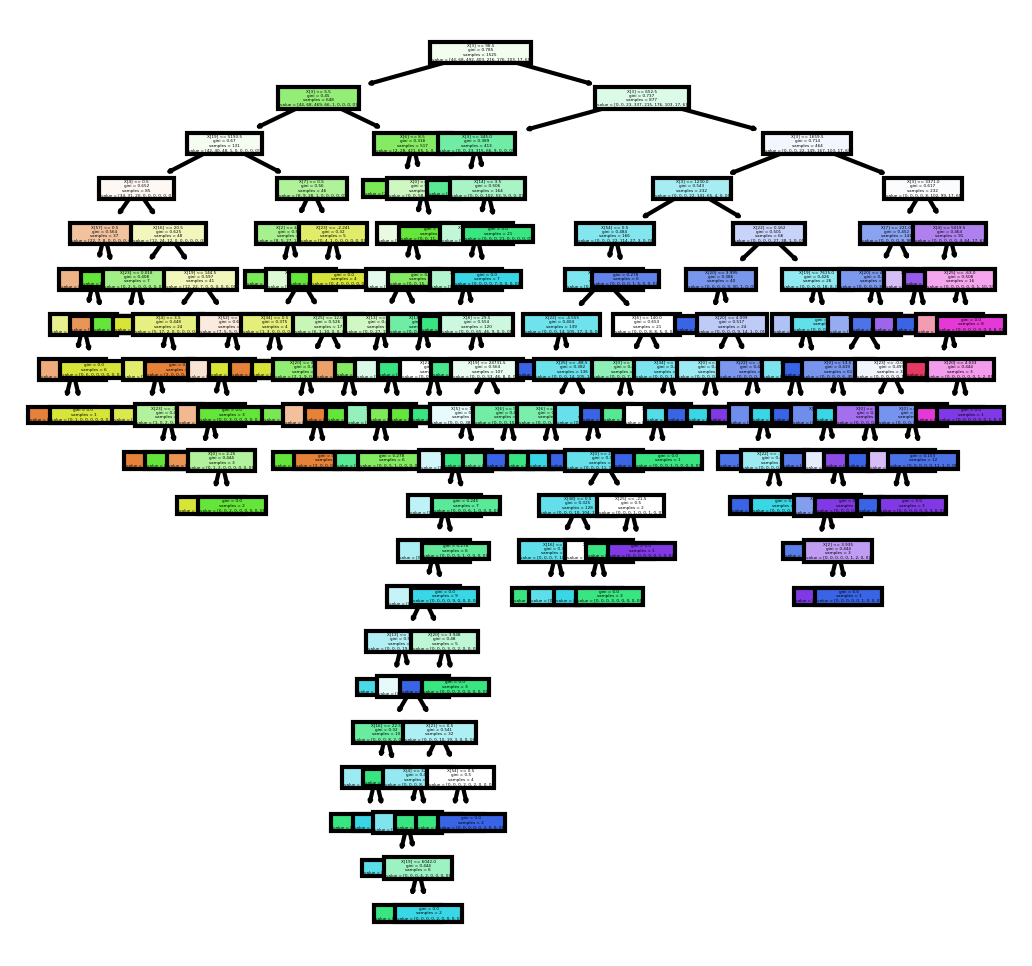

In [ ]:
## visualising the decision tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt.best_estimator_, filled = True);

### Bagging

In [24]:
from sklearn.ensemble import BaggingClassifier

In [27]:
dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42, max_features=45, min_impurity_split=0.3), n_estimators=50).fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will

In [31]:
y_pred_bag_test = dt.predict(X_test)
y_pred_bag_train = dt.predict(X_train)

print(accuracy_score(y_train, y_pred_bag_train))
print(accuracy_score(y_test, y_pred_bag_test))

0.8696412948381452
0.7539267015706806


### GridSearch

In [33]:
from sklearn.model_selection import GridSearchCV

n_estimators_range = [10,20,30,40,50]
max_samples_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
max_features_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
bootstrap_range = ['True', 'False']
bootstrap_features_range = ['True', 'False']
oob_score_range = ['True', 'False']
warm_start_range = ['True', 'False']

bag_param = [{'n_estimators': n_estimators_range,'max_samples':max_samples_range,\
               'max_features':max_features_range\
              #,'bootstrap':bootstrap_range,\
              #'bootstrap_features':bootstrap_features_range, 'oob_score':oob_score_range,\
              #'warm_start': warm_start_range\
             }]

dt = GridSearchCV(BaggingClassifier(random_state=42), bag_param, cv=3, scoring = 'accuracy',verbose = 3)
dt.fit(X, y)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] max_features=0.1, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=10, score=0.621, total=   0.0s
[CV] max_features=0.1, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=10, score=0.557, total=   0.0s
[CV] max_features=0.1, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=10, score=0.573, total=   0.0s
[CV] max_features=0.1, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=20, score=0.715, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=20 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

[CV]  max_features=0.1, max_samples=0.1, n_estimators=20, score=0.675, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=20, score=0.638, total=   0.0s
[CV] max_features=0.1, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=30, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=30, score=0.677, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.1, n_estimators=30, score=0.648, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=40, score=0.715, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=40, score=0.701, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.1, n_estimators=40, score=0.657, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=50, score=0.713, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.1, n_estimators=50, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.1, n_estimators=50, score=0.671, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=10, score=0.656, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=10, score=0.581, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=10, score=0.545, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=20, score=0.711, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=20, score=0.657, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.2, n_estimators=20, score=0.626, total=   0.0s
[CV] max_features=0.1, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=30, score=0.701, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=30, score=0.663, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=30, score=0.652, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.2, n_estimators=40, score=0.717, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=40, score=0.693, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=40, score=0.657, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.2, n_estimators=50, score=0.723, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=50, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.2, n_estimators=50, score=0.654, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.3, n_estimators=10, score=0.603, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=10, score=0.612, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=10, score=0.583, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=20, score=0.717, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=20, score=0.683, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=20, score=0.683, total=   0.0s
[CV] max_features=0.1, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.3, n_estimators=30, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=30, score=0.685, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=30, score=0.665, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.3, n_estimators=40, score=0.699, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=40, score=0.697, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=40, score=0.691, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.3, n_estimators=50, score=0.711, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.3, n_estimators=50, score=0.711, total=   0.1s
[CV] max_features=0.1, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.3, n_estimators=50, score=0.679, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=10, score=0.635, total=   0.0s
[CV] max_features=0.1, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=10, score=0.616, total=   0.0s
[CV] max_features=0.1, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=10, score=0.591, total=   0.0s
[CV] max_features=0.1, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=20, score=0.717, total=   0.0s
[CV] max_features=0.1, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=20, score=0.677, total=   0.0s
[CV] max_features=0.1, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.4, n_estimators=20, score=0.697, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=30, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=30, score=0.681, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.4, n_estimators=30, score=0.687, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=40, score=0.719, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=40, score=0.713, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.4, n_estimators=40, score=0.685, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=50, score=0.725, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.4, n_estimators=50, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.4, n_estimators=50, score=0.693, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=10, score=0.640, total=   0.0s
[CV] max_features=0.1, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=10, score=0.628, total=   0.0s
[CV] max_features=0.1, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=10, score=0.608, total=   0.0s
[CV] max_features=0.1, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.5, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=20, score=0.697, total=   0.0s
[CV] max_features=0.1, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=20, score=0.687, total=   0.0s
[CV] max_features=0.1, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=30, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.5, n_estimators=30, score=0.695, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=30, score=0.685, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.5, n_estimators=40, score=0.703, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=40, score=0.687, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.5, n_estimators=50, score=0.737, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.5, n_estimators=50, score=0.715, total=   0.1s
[CV] max_features=0.1, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.5, n_estimators=50, score=0.691, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=10, score=0.629, total=   0.0s
[CV] max_features=0.1, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=10, score=0.616, total=   0.0s
[CV] max_features=0.1, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=10, score=0.594, total=   0.0s
[CV] max_features=0.1, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=20, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=20, score=0.701, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.6, n_estimators=20, score=0.667, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=30, score=0.692, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=30, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.6, n_estimators=30, score=0.667, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=40, score=0.719, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=40, score=0.717, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.6, n_estimators=40, score=0.683, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=50, score=0.725, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.6, n_estimators=50, score=0.724, total=   0.1s
[CV] max_features=0.1, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.6, n_estimators=50, score=0.689, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=10, score=0.662, total=   0.0s
[CV] max_features=0.1, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=10, score=0.620, total=   0.0s
[CV] max_features=0.1, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.7, n_estimators=10, score=0.594, total=   0.0s
[CV] max_features=0.1, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=20, score=0.695, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=20, score=0.671, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.7, n_estimators=30, score=0.727, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=30, score=0.689, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=30, score=0.669, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.7, n_estimators=40, score=0.741, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=40, score=0.709, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.7, n_estimators=40, score=0.695, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=50, score=0.745, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.7, n_estimators=50, score=0.726, total=   0.1s
[CV] max_features=0.1, max_samples=0.7, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.7, n_estimators=50, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=10, score=0.646, total=   0.0s
[CV] max_features=0.1, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=10, score=0.616, total=   0.0s
[CV] max_features=0.1, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.8, n_estimators=10, score=0.600, total=   0.0s
[CV] max_features=0.1, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=20, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=20, score=0.671, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.8, n_estimators=30, score=0.731, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=30, score=0.695, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=30, score=0.675, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.8, n_estimators=40, score=0.754, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=40, score=0.709, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.8, n_estimators=40, score=0.689, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=50, score=0.762, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.8, n_estimators=50, score=0.722, total=   0.1s
[CV] max_features=0.1, max_samples=0.8, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.8, n_estimators=50, score=0.711, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=10, score=0.646, total=   0.0s
[CV] max_features=0.1, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=10, score=0.640, total=   0.0s
[CV] max_features=0.1, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.9, n_estimators=10, score=0.587, total=   0.0s
[CV] max_features=0.1, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=20, score=0.711, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=20, score=0.705, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=20, score=0.679, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.1, max_samples=0.9, n_estimators=30, score=0.713, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=30, score=0.697, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=30, score=0.683, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.9, n_estimators=40, score=0.733, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=40 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=40, score=0.713, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.9, n_estimators=40, score=0.695, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=50, score=0.749, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.1, max_samples=0.9, n_estimators=50, score=0.720, total=   0.1s
[CV] max_features=0.1, max_samples=0.9, n_estimators=50 ..............
[CV]  max_features=0.1, max_samples=0.9, n_estimators=50, score=0.705, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=10, score=0.705, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=10, score=0.711, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.1, n_estimators=10, score=0.675, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=20, score=0.727, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=20, score=0.724, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=20, score=0.685, total=   0.0s
[CV] max_features=0.2, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=30, score=0.723, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.1, n_estimators=30, score=0.736, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=30, score=0.695, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.1, n_estimators=40, score=0.732, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=40, score=0.681, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=50, score=0.731, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.1, n_estimators=50, score=0.726, total=   0.1s
[CV] max_features=0.2, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.1, n_estimators=50, score=0.701, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=10, score=0.703, total=   0.0s
[CV] max_features=0.2, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=10, score=0.697, total=   0.0s
[CV] max_features=0.2, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=10, score=0.656, total=   0.0s
[CV] max_features=0.2, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.2, n_estimators=20, score=0.723, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=20, score=0.719, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=20, score=0.683, total=   0.0s
[CV] max_features=0.2, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=30, score=0.715, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.2, n_estimators=30, score=0.720, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=30, score=0.695, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.2, n_estimators=40, score=0.736, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=40, score=0.697, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.2, n_estimators=50, score=0.743, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.2, n_estimators=50, score=0.740, total=   0.1s
[CV] max_features=0.2, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.2, n_estimators=50, score=0.691, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=10, score=0.721, total=   0.0s
[CV] max_features=0.2, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=10, score=0.730, total=   0.0s
[CV] max_features=0.2, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=10, score=0.685, total=   0.0s
[CV] max_features=0.2, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=20, score=0.731, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.3, n_estimators=20, score=0.736, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=20, score=0.701, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=30, score=0.739, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.3, n_estimators=30, score=0.738, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=30, score=0.701, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=40, score=0.725, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.3, n_estimators=40, score=0.754, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=40, score=0.699, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.3, n_estimators=50, score=0.739, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.3, n_estimators=50, score=0.744, total=   0.1s
[CV] max_features=0.2, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.3, n_estimators=50, score=0.699, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.2, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.2, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=10, score=0.669, total=   0.0s
[CV] max_features=0.2, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=20, score=0.749, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.4, n_estimators=20, score=0.742, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=20, score=0.693, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=30, score=0.737, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.4, n_estimators=30, score=0.746, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=30, score=0.699, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.4, n_estimators=40, score=0.750, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=40, score=0.740, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.4, n_estimators=40, score=0.707, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=50, score=0.750, total=   0.1s
[CV] max_features=0.2, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.4, n_estimators=50, score=0.742, total=   0.2s
[CV] max_features=0.2, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.4, n_estimators=50, score=0.691, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.2, max_samples=0.5, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.5, n_estimators=10, score=0.736, total=   0.0s
[CV] max_features=0.2, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=10, score=0.677, total=   0.0s
[CV] max_features=0.2, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.5, n_estimators=20, score=0.720, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=30, score=0.772, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.5, n_estimators=30, score=0.715, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=40, score=0.770, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.5, n_estimators=40, score=0.752, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=40, score=0.713, total=   0.1s
[CV] max_features=0.2, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.5, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.2, max_samples=0.5, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.5, n_estimators=50, score=0.750, total=   0.2s
[CV] max_features=0.2, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.5, n_estimators=50, score=0.709, total=   0.2s
[CV] max_features=0.2, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=10, score=0.733, total=   0.0s
[CV] max_features=0.2, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=10, score=0.728, total=   0.0s
[CV] max_features=0.2, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=10, score=0.687, total=   0.0s
[CV] max_features=0.2, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=20, score=0.749, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.6, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=20, score=0.722, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=30, score=0.766, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.6, n_estimators=30, score=0.758, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=30, score=0.720, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.6, n_estimators=40, score=0.762, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=40, score=0.748, total=   0.1s
[CV] max_features=0.2, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.6, n_estimators=40, score=0.707, total=   0.2s
[CV] max_features=0.2, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=50, score=0.756, total=   0.2s
[CV] max_features=0.2, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.6, n_estimators=50, score=0.748, total=   0.2s
[CV] max_features=0.2, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.6, n_estimators=50, score=0.703, total=   0.2s
[CV] max_features=0.2, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.7, n_estimators=10, score=0.758, total=   0.0s
[CV] max_features=0.2, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=10, score=0.738, total=   0.0s
[CV] max_features=0.2, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=10, score=0.689, total=   0.0s
[CV] max_features=0.2, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=20, score=0.768, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.7, n_estimators=20, score=0.760, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=30, score=0.766, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.7, n_estimators=30, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=30, score=0.720, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.7, n_estimators=40, score=0.776, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=40, score=0.758, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.7, n_estimators=40, score=0.726, total=   0.1s
[CV] max_features=0.2, max_samples=0.7, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=50, score=0.770, total=   0.2s
[CV] max_features=0.2, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.7, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.2, max_samples=0.7, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.7, n_estimators=50, score=0.709, total=   0.2s
[CV] max_features=0.2, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.8, n_estimators=10, score=0.735, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=10, score=0.726, total=   0.0s
[CV] max_features=0.2, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=10, score=0.693, total=   0.0s
[CV] max_features=0.2, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=20, score=0.745, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.8, n_estimators=20, score=0.758, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=30, score=0.752, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.8, n_estimators=30, score=0.744, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=30, score=0.715, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.8, n_estimators=40, score=0.774, total=   0.2s
[CV] max_features=0.2, max_samples=0.8, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=40, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.8, n_estimators=40, score=0.719, total=   0.2s
[CV] max_features=0.2, max_samples=0.8, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.2, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.8, n_estimators=50, score=0.756, total=   0.2s
[CV] max_features=0.2, max_samples=0.8, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.8, n_estimators=50, score=0.720, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.9, n_estimators=10, score=0.723, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=10, score=0.742, total=   0.0s
[CV] max_features=0.2, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=10, score=0.699, total=   0.0s
[CV] max_features=0.2, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.2, max_samples=0.9, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=20, score=0.724, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=30, score=0.764, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.9, n_estimators=30, score=0.766, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=30, score=0.720, total=   0.1s
[CV] max_features=0.2, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.9, n_estimators=40, score=0.772, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=40 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=40, score=0.772, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.9, n_estimators=40, score=0.717, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.2, max_samples=0.9, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.2, max_samples=0.9, n_estimators=50 ..............
[CV]  max_features=0.2, max_samples=0.9, n_estimators=50, score=0.722, total=   0.2s
[CV] max_features=0.3, max_samples=0.1, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.1, n_estimators=10, score=0.699, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=10, score=0.709, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=10, score=0.673, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=20, score=0.733, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=20, score=0.754, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=20, score=0.683, total=   0.0s
[CV] max_features=0.3, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.1, n_estimators=30, score=0.729, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=30, score=0.679, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.1, n_estimators=40, score=0.725, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=40, score=0.752, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=40, score=0.677, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.1, n_estimators=50, score=0.731, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.1, n_estimators=50, score=0.746, total=   0.1s
[CV] max_features=0.3, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.1, n_estimators=50, score=0.687, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=10, score=0.731, total=   0.0s
[CV] max_features=0.3, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=10, score=0.732, total=   0.0s
[CV] max_features=0.3, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=10, score=0.691, total=   0.0s
[CV] max_features=0.3, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=20, score=0.731, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=20, score=0.736, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.2, n_estimators=20, score=0.693, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=30, score=0.741, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.2, n_estimators=30, score=0.707, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=40, score=0.737, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.2, n_estimators=40, score=0.734, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=40, score=0.717, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.2, n_estimators=50, score=0.737, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.2, n_estimators=50, score=0.740, total=   0.1s
[CV] max_features=0.3, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.2, n_estimators=50, score=0.707, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=10, score=0.723, total=   0.0s
[CV] max_features=0.3, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=10, score=0.730, total=   0.0s
[CV] max_features=0.3, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=10, score=0.699, total=   0.0s
[CV] max_features=0.3, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=20, score=0.749, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.3, n_estimators=20, score=0.748, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=20, score=0.713, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=30, score=0.752, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.3, n_estimators=30, score=0.752, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=30, score=0.713, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.3, n_estimators=40, score=0.741, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=40, score=0.744, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.3, n_estimators=40, score=0.717, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=50, score=0.756, total=   0.2s
[CV] max_features=0.3, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.3, n_estimators=50, score=0.758, total=   0.1s
[CV] max_features=0.3, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.3, n_estimators=50, score=0.717, total=   0.2s
[CV] max_features=0.3, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.3, max_samples=0.4, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.4, n_estimators=10, score=0.734, total=   0.0s
[CV] max_features=0.3, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=10, score=0.697, total=   0.0s
[CV] max_features=0.3, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=20, score=0.725, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=20, score=0.742, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.4, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=30, score=0.745, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=30, score=0.758, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=30, score=0.711, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.4, n_estimators=40, score=0.749, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=40, score=0.760, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.4, n_estimators=40, score=0.722, total=   0.1s
[CV] max_features=0.3, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=50, score=0.756, total=   0.2s
[CV] max_features=0.3, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.4, n_estimators=50, score=0.762, total=   0.2s
[CV] max_features=0.3, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.4, n_estimators=50, score=0.713, total=   0.2s
[CV] max_features=0.3, max_samples=0.5, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.5, n_estimators=10, score=0.741, total=   0.0s
[CV] max_features=0.3, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=10, score=0.760, total=   0.0s
[CV] max_features=0.3, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=10, score=0.713, total=   0.0s
[CV] max_features=0.3, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=20, score=0.762, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.5, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=20, score=0.722, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=30, score=0.776, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.5, n_estimators=30, score=0.760, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=30, score=0.730, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.5, n_estimators=40, score=0.770, total=   0.2s
[CV] max_features=0.3, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=40, score=0.764, total=   0.1s
[CV] max_features=0.3, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.5, n_estimators=40, score=0.732, total=   0.2s
[CV] max_features=0.3, max_samples=0.5, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=50, score=0.770, total=   0.2s
[CV] max_features=0.3, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.5, n_estimators=50, score=0.762, total=   0.2s
[CV] max_features=0.3, max_samples=0.5, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.5, n_estimators=50, score=0.720, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.6, n_estimators=10, score=0.745, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=10, score=0.760, total=   0.0s
[CV] max_features=0.3, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=10, score=0.701, total=   0.0s
[CV] max_features=0.3, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=20, score=0.745, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.6, n_estimators=20, score=0.774, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=20, score=0.713, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=30, score=0.768, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.6, n_estimators=30, score=0.764, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=30, score=0.730, total=   0.1s
[CV] max_features=0.3, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.6, n_estimators=40, score=0.762, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=40, score=0.770, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.6, n_estimators=40, score=0.720, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=50, score=0.756, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.6, n_estimators=50, score=0.764, total=   0.2s
[CV] max_features=0.3, max_samples=0.6, n_estimators=50 ..............
[CV]  max_features=0.3, max_samples=0.6, n_estimators=50, score=0.715, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=10, score=0.747, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=10, score=0.752, total=   0.0s
[CV] max_features=0.3, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=10, score=0.711, total=   0.0s
[CV] max_features=0.3, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=20, score=0.758, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.7, n_estimators=20, score=0.766, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=20, score=0.744, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=30, score=0.774, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=30, score=0.776, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=30, score=0.736, total=   0.1s
[CV] max_features=0.3, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=40, score=0.760, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=40, score=0.772, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.7, n_estimators=40, score=0.730, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=50, score=0.754, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=50, score=0.770, total=   0.2s
[CV] max_features=0.3, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.7, n_estimators=50, score=0.719, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=10, score=0.758, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=10, score=0.744, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=10, score=0.717, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.8, n_estimators=20, score=0.752, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=20, score=0.719, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=30, score=0.745, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=30, score=0.764, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=30, score=0.728, total=   0.1s
[CV] max_features=0.3, max_samples=0.8, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=40, score=0.743, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=40, score=0.776, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.8, n_estimators=40, score=0.728, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=50, score=0.750, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=50, score=0.781, total=   0.2s
[CV] max_features=0.3, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.8, n_estimators=50, score=0.724, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=10, score=0.776, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=10, score=0.732, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=10, score=0.705, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.3, max_samples=0.9, n_estimators=20, score=0.774, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=20, score=0.766, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=20, score=0.711, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=30, score=0.770, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=30, score=0.778, total=   0.1s
[CV] max_features=0.3, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=30, score=0.726, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=40, score=0.760, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=40, score=0.781, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=40 ..............
[CV]  max_features=0.3, max_samples=0.9, n_estimators=40, score=0.720, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=50, score=0.764, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=50, score=0.781, total=   0.2s
[CV] max_features=0.3, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.3, max_samples=0.9, n_estimators=50, score=0.720, total=   0.2s
[CV] max_features=0.4, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=10, score=0.699, total=   0.0s
[CV] max_features=0.4, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=10, score=0.732, total=   0.0s
[CV] max_features=0.4, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=10, score=0.657, total=   0.0s
[CV] max_features=0.4, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=20, score=0.719, total=   0.0s
[CV] max_features=0.4, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=20, score=0.738, total=   0.0s
[CV] max_features=0.4, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.1, n_estimators=20, score=0.677, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=30, score=0.715, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=30, score=0.740, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=30, score=0.683, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.1, n_estimators=40, score=0.721, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=40, score=0.736, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=40, score=0.681, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.1, n_estimators=50, score=0.731, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.1, n_estimators=50, score=0.734, total=   0.1s
[CV] max_features=0.4, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.1, n_estimators=50, score=0.683, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=10, score=0.727, total=   0.0s
[CV] max_features=0.4, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=10, score=0.722, total=   0.0s
[CV] max_features=0.4, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=10, score=0.719, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.2, n_estimators=20, score=0.750, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=20, score=0.730, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=30, score=0.731, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.2, n_estimators=30, score=0.746, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=30, score=0.711, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.2, n_estimators=40, score=0.742, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=40, score=0.709, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.2, n_estimators=50, score=0.733, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.2, n_estimators=50, score=0.744, total=   0.1s
[CV] max_features=0.4, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.2, n_estimators=50, score=0.699, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.4, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=10, score=0.730, total=   0.0s
[CV] max_features=0.4, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=10, score=0.709, total=   0.0s
[CV] max_features=0.4, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=20, score=0.749, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.3, n_estimators=20, score=0.722, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=20, score=0.695, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=30, score=0.762, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.3, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=30, score=0.711, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.3, n_estimators=40, score=0.754, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=40, score=0.744, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.3, n_estimators=40, score=0.713, total=   0.1s
[CV] max_features=0.4, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=50, score=0.764, total=   0.2s
[CV] max_features=0.4, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.3, n_estimators=50, score=0.736, total=   0.2s
[CV] max_features=0.4, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.3, n_estimators=50, score=0.715, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=10, score=0.733, total=   0.0s
[CV] max_features=0.4, max_samples=0.4, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.4, n_estimators=10, score=0.726, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=10, score=0.687, total=   0.0s
[CV] max_features=0.4, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.4, n_estimators=20, score=0.738, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=20, score=0.693, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.4, n_estimators=30, score=0.760, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=30, score=0.713, total=   0.1s
[CV] max_features=0.4, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.4, n_estimators=40, score=0.752, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=40, score=0.772, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.4, n_estimators=40, score=0.709, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.4, n_estimators=50, score=0.778, total=   0.2s
[CV] max_features=0.4, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.4, max_samples=0.4, n_estimators=50, score=0.713, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=10, score=0.743, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=10, score=0.774, total=   0.0s
[CV] max_features=0.4, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=10, score=0.709, total=   0.0s
[CV] max_features=0.4, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.5, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=20, score=0.707, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=30, score=0.752, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=30, score=0.789, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=30, score=0.715, total=   0.1s
[CV] max_features=0.4, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=40, score=0.752, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=40, score=0.785, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.5, n_estimators=40, score=0.719, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=50, score=0.780, total=   0.2s
[CV] max_features=0.4, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.5, n_estimators=50, score=0.717, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=10, score=0.745, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=10, score=0.730, total=   0.0s
[CV] max_features=0.4, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=10, score=0.717, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.6, n_estimators=20, score=0.754, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=20, score=0.709, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=30, score=0.770, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=30, score=0.772, total=   0.1s
[CV] max_features=0.4, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=30, score=0.715, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=40, score=0.774, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=40, score=0.781, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.6, n_estimators=40, score=0.715, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=50, score=0.783, total=   0.2s
[CV] max_features=0.4, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.6, n_estimators=50, score=0.715, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=10, score=0.732, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=10, score=0.719, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.7, n_estimators=20, score=0.768, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=20, score=0.726, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=30, score=0.772, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=30, score=0.772, total=   0.1s
[CV] max_features=0.4, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=30, score=0.734, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=40, score=0.766, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=40, score=0.781, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.4, max_samples=0.7, n_estimators=40, score=0.720, total=   0.2s
[CV] max_features=0.4, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=50, score=0.764, total=   0.3s
[CV] max_features=0.4, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=50, score=0.780, total=   0.3s
[CV] max_features=0.4, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.7, n_estimators=50, score=0.726, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=10, score=0.745, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=10, score=0.736, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=10, score=0.693, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.8, n_estimators=20, score=0.770, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=20, score=0.701, total=   0.1s
[CV] max_features=0.4, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=30, score=0.768, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=30, score=0.791, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.8, n_estimators=30, score=0.707, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=40, score=0.760, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=40, score=0.785, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=40, score=0.717, total=   0.2s
[CV] max_features=0.4, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=50, score=0.756, total=   0.3s
[CV] max_features=0.4, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=50, score=0.791, total=   0.3s
[CV] max_features=0.4, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.8, n_estimators=50, score=0.717, total=   0.3s
[CV] max_features=0.4, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=10, score=0.768, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=10, score=0.752, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=10, score=0.703, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.4, max_samples=0.9, n_estimators=20, score=0.778, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=20, score=0.781, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=20, score=0.720, total=   0.1s
[CV] max_features=0.4, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=30, score=0.809, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=30, score=0.787, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.4, max_samples=0.9, n_estimators=30, score=0.726, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=40, score=0.792, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=40, score=0.774, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=40, score=0.722, total=   0.2s
[CV] max_features=0.4, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=50, score=0.778, total=   0.3s
[CV] max_features=0.4, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=50, score=0.781, total=   0.3s
[CV] max_features=0.4, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.4, max_samples=0.9, n_estimators=50, score=0.715, total=   0.3s
[CV] max_features=0.5, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=10, score=0.741, total=   0.0s
[CV] max_features=0.5, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=10, score=0.740, total=   0.0s
[CV] max_features=0.5, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=10, score=0.667, total=   0.0s
[CV] max_features=0.5, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=20, score=0.731, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.1, n_estimators=20, score=0.732, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=20, score=0.665, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=30, score=0.721, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.1, n_estimators=30, score=0.732, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=30, score=0.677, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=40, score=0.717, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.1, n_estimators=40, score=0.742, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=40, score=0.675, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.1, n_estimators=50, score=0.721, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.1, n_estimators=50, score=0.746, total=   0.1s
[CV] max_features=0.5, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.1, n_estimators=50, score=0.677, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=10, score=0.717, total=   0.0s
[CV] max_features=0.5, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=10, score=0.728, total=   0.0s
[CV] max_features=0.5, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=10, score=0.705, total=   0.0s
[CV] max_features=0.5, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.2, n_estimators=20, score=0.740, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=20, score=0.689, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=30, score=0.719, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.2, n_estimators=30, score=0.760, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=30, score=0.701, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.2, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=40, score=0.758, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.2, n_estimators=40, score=0.705, total=   0.1s
[CV] max_features=0.5, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=50, score=0.725, total=   0.2s
[CV] max_features=0.5, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.2, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.5, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.2, n_estimators=50, score=0.701, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.3, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.5, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=10, score=0.713, total=   0.0s
[CV] max_features=0.5, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=10, score=0.677, total=   0.0s
[CV] max_features=0.5, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=20, score=0.749, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.3, n_estimators=20, score=0.738, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=20, score=0.689, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=30, score=0.750, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.3, n_estimators=30, score=0.754, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=30, score=0.697, total=   0.1s
[CV] max_features=0.5, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.3, n_estimators=40, score=0.750, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=40, score=0.758, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.3, n_estimators=40, score=0.701, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=50, score=0.749, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.3, n_estimators=50, score=0.766, total=   0.2s
[CV] max_features=0.5, max_samples=0.3, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.3, n_estimators=50, score=0.707, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=10, score=0.739, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=10, score=0.738, total=   0.0s
[CV] max_features=0.5, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.5, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=20, score=0.733, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.4, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=30, score=0.747, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=30, score=0.766, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=30, score=0.717, total=   0.1s
[CV] max_features=0.5, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=40, score=0.756, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=40, score=0.774, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=40, score=0.713, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=50, score=0.768, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=50 ..............
[CV]  max_features=0.5, max_samples=0.4, n_estimators=50, score=0.762, total=   0.2s
[CV] max_features=0.5, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.4, n_estimators=50, score=0.715, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=10, score=0.747, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=10, score=0.758, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=10, score=0.701, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.5, n_estimators=20, score=0.760, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=20, score=0.770, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=20, score=0.709, total=   0.1s

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] max_features=0.5, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=30, score=0.764, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=30, score=0.780, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=30, score=0.707, total=   0.1s
[CV] max_features=0.5, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=40, score=0.750, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.5, n_estimators=40, score=0.781, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=40, score=0.715, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=50, score=0.752, total=   0.2s
[CV] max_features=0.5, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=50, score=0.785, total=   0.3s
[CV] max_features=0.5, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.5, n_estimators=50, score=0.703, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=10, score=0.754, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=10, score=0.748, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=10, score=0.719, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.6, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=20, score=0.766, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=20, score=0.724, total=   0.1s
[CV] max_features=0.5, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=30, score=0.762, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=30, score=0.780, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.6, n_estimators=30, score=0.722, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=40, score=0.768, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=40, score=0.783, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=40, score=0.726, total=   0.2s
[CV] max_features=0.5, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=50, score=0.770, total=   0.3s
[CV] max_features=0.5, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=50, score=0.780, total=   0.3s
[CV] max_features=0.5, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.6, n_estimators=50, score=0.726, total=   0.3s
[CV] max_features=0.5, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=10, score=0.754, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=10, score=0.744, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.5, max_samples=0.7, n_estimators=10, score=0.711, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=20, score=0.766, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.5, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=30, score=0.762, total=   0.2s
[CV] max_features=0.5, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=30, score=0.783, total=   0.2s
[CV] max_features=0.5, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=30, score=0.728, total=   0.2s
[CV] max_features=0.5, max_samples=0.7, n_estimators=40 ..............
[CV]  max_features=0.5, max_samples=0.7, n_estimators=40, score=0.764, total=   0.2s
[CV] max_features=0.5, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=40, score=0.789, total=   0.3s
[CV] max_features=0.5, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=40, score=0.728, total=   0.2s
[CV] max_features=0.5, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=50, score=0.764, total=   0.3s
[CV] max_features=0.5, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=50, score=0.783, total=   0.3s
[CV] max_features=0.5, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.7, n_estimators=50, score=0.722, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.8, n_estimators=10, score=0.747, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.8, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=10, score=0.709, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.8, n_estimators=20, score=0.776, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=20, score=0.780, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.8, n_estimators=20, score=0.715, total=   0.1s
[CV] max_features=0.5, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=30, score=0.760, total=   0.2s
[CV] max_features=0.5, max_samples=0.8, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.8, n_estimators=30, score=0.783, total=   0.2s
[CV] max_features=0.5, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=30, score=0.707, total=   0.2s
[CV] max_features=0.5, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=40, score=0.752, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=40, score=0.791, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=40, score=0.707, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=50, score=0.762, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=50, score=0.791, total=   0.3s
[CV] max_features=0.5, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.8, n_estimators=50, score=0.709, total=   0.3s
[CV] max_features=0.5, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.9, n_estimators=10, score=0.772, total=   0.1s
[CV] max_features=0.5, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.5, max_samples=0.9, n_estimators=10, score=0.754, total=   0.1s
[CV] max_features=0.5, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=10, score=0.707, total=   0.1s
[CV] max_features=0.5, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.9, n_estimators=20, score=0.774, total=   0.1s
[CV] max_features=0.5, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=20, score=0.774, total=   0.2s
[CV] max_features=0.5, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.5, max_samples=0.9, n_estimators=20, score=0.709, total=   0.1s
[CV] max_features=0.5, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=30, score=0.786, total=   0.2s
[CV] max_features=0.5, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.5, max_samples=0.9, n_estimators=30, score=0.783, total=   0.2s
[CV] max_features=0.5, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=30, score=0.719, total=   0.2s
[CV] max_features=0.5, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=40, score=0.770, total=   0.3s
[CV] max_features=0.5, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=40, score=0.781, total=   0.3s
[CV] max_features=0.5, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=40, score=0.717, total=   0.3s
[CV] max_features=0.5, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=50, score=0.749, total=   0.4s
[CV] max_features=0.5, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=50, score=0.789, total=   0.3s
[CV] max_features=0.5, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.5, max_samples=0.9, n_estimators=50, score=0.715, total=   0.3s
[CV] max_features=0.6, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=10, score=0.721, total=   0.0s
[CV] max_features=0.6, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=10, score=0.713, total=   0.0s
[CV] max_features=0.6, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=10, score=0.681, total=   0.0s
[CV] max_features=0.6, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=20, score=0.719, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.6, max_samples=0.1, n_estimators=20, score=0.732, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=20, score=0.675, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=30, score=0.725, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.1, n_estimators=30, score=0.738, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=30, score=0.671, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=40, score=0.723, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.1, n_estimators=40, score=0.734, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=40, score=0.681, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.1, n_estimators=50, score=0.717, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.6, max_samples=0.1, n_estimators=50, score=0.740, total=   0.1s
[CV] max_features=0.6, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.1, n_estimators=50, score=0.687, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.6, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.6, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=10, score=0.683, total=   0.0s
[CV] max_features=0.6, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.6, max_samples=0.2, n_estimators=20, score=0.724, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=20, score=0.685, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=30, score=0.737, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.2, n_estimators=30, score=0.748, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=30, score=0.711, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.2, n_estimators=40, score=0.737, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=40, score=0.754, total=   0.1s
[CV] max_features=0.6, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.2, n_estimators=40, score=0.705, total=   0.2s
[CV] max_features=0.6, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=50, score=0.743, total=   0.2s
[CV] max_features=0.6, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.2, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.6, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.6, max_samples=0.2, n_estimators=50, score=0.699, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=10, score=0.735, total=   0.0s
[CV] max_features=0.6, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=10, score=0.750, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=10, score=0.699, total=   0.0s
[CV] max_features=0.6, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=20, score=0.741, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=20, score=0.746, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=30, score=0.743, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=30, score=0.764, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=30, score=0.701, total=   0.1s
[CV] max_features=0.6, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=40, score=0.743, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=40, score=0.766, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.3, n_estimators=40, score=0.715, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=50, score=0.743, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=50, score=0.766, total=   0.2s
[CV] max_features=0.6, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.3, n_estimators=50, score=0.715, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=10, score=0.707, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=10, score=0.752, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=10, score=0.695, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.6, max_samples=0.4, n_estimators=20, score=0.739, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=20, score=0.770, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=20, score=0.689, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=30, score=0.752, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=30, score=0.787, total=   0.1s
[CV] max_features=0.6, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=30, score=0.693, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=40, score=0.764, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=40, score=0.772, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.6, max_samples=0.4, n_estimators=40, score=0.713, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=50, score=0.754, total=   0.3s
[CV] max_features=0.6, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=50, score=0.772, total=   0.2s
[CV] max_features=0.6, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.4, n_estimators=50, score=0.711, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=10, score=0.743, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=10, score=0.752, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=10, score=0.717, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.6, max_samples=0.5, n_estimators=20, score=0.752, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=20, score=0.768, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=20, score=0.707, total=   0.1s
[CV] max_features=0.6, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=30, score=0.750, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=30, score=0.774, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.5, n_estimators=30, score=0.709, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=40, score=0.762, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=40, score=0.778, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=40, score=0.703, total=   0.2s
[CV] max_features=0.6, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=50, score=0.758, total=   0.3s
[CV] max_features=0.6, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=50, score=0.781, total=   0.3s
[CV] max_features=0.6, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.5, n_estimators=50, score=0.699, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=10, score=0.756, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=10, score=0.711, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.6, max_samples=0.6, n_estimators=20, score=0.754, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=20, score=0.783, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=20, score=0.705, total=   0.1s
[CV] max_features=0.6, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=30, score=0.754, total=   0.2s
[CV] max_features=0.6, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=30, score=0.781, total=   0.2s
[CV] max_features=0.6, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.6, n_estimators=30, score=0.703, total=   0.2s
[CV] max_features=0.6, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=40, score=0.764, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=40, score=0.778, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=40, score=0.707, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=50, score=0.760, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=50, score=0.783, total=   0.3s
[CV] max_features=0.6, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.6, n_estimators=50, score=0.709, total=   0.3s
[CV] max_features=0.6, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=10, score=0.756, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=10, score=0.744, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=10, score=0.713, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=20, score=0.770, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=20, score=0.764, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=20, score=0.724, total=   0.1s
[CV] max_features=0.6, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=30, score=0.766, total=   0.2s
[CV] max_features=0.6, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=30, score=0.781, total=   0.2s

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] max_features=0.6, max_samples=0.7, n_estimators=30 ..............
[CV]  max_features=0.6, max_samples=0.7, n_estimators=30, score=0.728, total=   0.2s
[CV] max_features=0.6, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=40, score=0.758, total=   0.3s
[CV] max_features=0.6, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=40, score=0.783, total=   0.3s
[CV] max_features=0.6, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=40, score=0.717, total=   0.3s
[CV] max_features=0.6, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=50, score=0.760, total=   0.4s
[CV] max_features=0.6, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=50, score=0.785, total=   0.3s
[CV] max_features=0.6, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.7, n_estimators=50, score=0.720, total=   0.3s
[CV] max_features=0.6, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.8, n_estimators=10, score=0.762, total=   0.1s
[CV] max_features=0.6, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.8, n_estimators=10, score=0.748, total=   0.1s
[CV] max_features=0.6, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=10, score=0.711, total=   0.1s
[CV] max_features=0.6, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.8, n_estimators=20, score=0.760, total=   0.1s
[CV] max_features=0.6, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=20, score=0.768, total=   0.2s
[CV] max_features=0.6, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.8, n_estimators=20, score=0.713, total=   0.1s
[CV] max_features=0.6, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=30, score=0.758, total=   0.2s
[CV] max_features=0.6, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=30, score=0.772, total=   0.2s
[CV] max_features=0.6, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=30, score=0.705, total=   0.2s
[CV] max_features=0.6, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=40, score=0.760, total=   0.3s
[CV] max_features=0.6, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=40, score=0.783, total=   0.3s
[CV] max_features=0.6, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=40, score=0.719, total=   0.3s
[CV] max_features=0.6, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=50, score=0.758, total=   0.4s
[CV] max_features=0.6, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=50, score=0.772, total=   0.4s
[CV] max_features=0.6, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.8, n_estimators=50, score=0.717, total=   0.4s
[CV] max_features=0.6, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.9, n_estimators=10, score=0.768, total=   0.1s
[CV] max_features=0.6, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.6, max_samples=0.9, n_estimators=10, score=0.770, total=   0.1s
[CV] max_features=0.6, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=10, score=0.709, total=   0.1s
[CV] max_features=0.6, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.9, n_estimators=20, score=0.764, total=   0.2s
[CV] max_features=0.6, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=20, score=0.772, total=   0.2s
[CV] max_features=0.6, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.6, max_samples=0.9, n_estimators=20, score=0.722, total=   0.1s
[CV] max_features=0.6, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=30, score=0.766, total=   0.2s
[CV] max_features=0.6, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=30, score=0.781, total=   0.2s
[CV] max_features=0.6, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=30, score=0.728, total=   0.2s
[CV] max_features=0.6, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=40, score=0.770, total=   0.3s
[CV] max_features=0.6, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=40, score=0.780, total=   0.3s
[CV] max_features=0.6, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=40, score=0.724, total=   0.3s
[CV] max_features=0.6, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=50, score=0.774, total=   0.4s
[CV] max_features=0.6, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=50, score=0.776, total=   0.4s
[CV] max_features=0.6, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.6, max_samples=0.9, n_estimators=50, score=0.709, total=   0.4s
[CV] max_features=0.7, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=10, score=0.723, total=   0.0s
[CV] max_features=0.7, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=10, score=0.719, total=   0.0s
[CV] max_features=0.7, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=10, score=0.656, total=   0.0s
[CV] max_features=0.7, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.7, max_samples=0.1, n_estimators=20, score=0.752, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=20, score=0.679, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=30, score=0.719, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.1, n_estimators=30, score=0.738, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=30, score=0.677, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=40, score=0.725, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.1, n_estimators=40, score=0.730, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=40, score=0.671, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.1, n_estimators=50, score=0.725, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.7, max_samples=0.1, n_estimators=50, score=0.736, total=   0.1s
[CV] max_features=0.7, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.1, n_estimators=50, score=0.679, total=   0.2s
[CV] max_features=0.7, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=10, score=0.727, total=   0.0s
[CV] max_features=0.7, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=10, score=0.750, total=   0.0s
[CV] max_features=0.7, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=10, score=0.673, total=   0.0s
[CV] max_features=0.7, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.7, max_samples=0.2, n_estimators=20, score=0.743, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=20, score=0.748, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=20, score=0.673, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.2, n_estimators=30, score=0.731, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=30, score=0.768, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.2, n_estimators=30, score=0.687, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=40, score=0.731, total=   0.2s
[CV] max_features=0.7, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.2, n_estimators=40, score=0.766, total=   0.2s
[CV] max_features=0.7, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=40, score=0.693, total=   0.1s
[CV] max_features=0.7, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.2, n_estimators=50, score=0.739, total=   0.2s
[CV] max_features=0.7, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.7, max_samples=0.2, n_estimators=50, score=0.760, total=   0.2s
[CV] max_features=0.7, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.2, n_estimators=50, score=0.697, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=10, score=0.715, total=   0.0s
[CV] max_features=0.7, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=10, score=0.726, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=10, score=0.691, total=   0.0s
[CV] max_features=0.7, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.7, max_samples=0.3, n_estimators=20, score=0.747, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=20, score=0.740, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=20, score=0.685, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=30, score=0.743, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=30, score=0.754, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=30, score=0.707, total=   0.1s
[CV] max_features=0.7, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=40, score=0.749, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=40, score=0.756, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.7, max_samples=0.3, n_estimators=40, score=0.699, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=50, score=0.749, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=50, score=0.752, total=   0.2s
[CV] max_features=0.7, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.3, n_estimators=50, score=0.707, total=   0.2s
[CV] max_features=0.7, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=10, score=0.721, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=10, score=0.746, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=10, score=0.697, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.7, max_samples=0.4, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=20, score=0.774, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=20, score=0.693, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=30, score=0.737, total=   0.2s
[CV] max_features=0.7, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=30, score=0.778, total=   0.2s
[CV] max_features=0.7, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.4, n_estimators=30, score=0.701, total=   0.1s
[CV] max_features=0.7, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=40, score=0.754, total=   0.2s
[CV] max_features=0.7, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=40, score=0.770, total=   0.2s
[CV] max_features=0.7, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=40, score=0.707, total=   0.3s
[CV] max_features=0.7, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=50, score=0.743, total=   0.3s
[CV] max_features=0.7, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=50, score=0.776, total=   0.3s
[CV] max_features=0.7, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.4, n_estimators=50, score=0.707, total=   0.3s
[CV] max_features=0.7, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=10, score=0.741, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=10, score=0.774, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=10, score=0.713, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.7, max_samples=0.5, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=20, score=0.787, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.7, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=30, score=0.754, total=   0.2s
[CV] max_features=0.7, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=30, score=0.776, total=   0.2s
[CV] max_features=0.7, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.5, n_estimators=30, score=0.691, total=   0.2s
[CV] max_features=0.7, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=40, score=0.754, total=   0.3s
[CV] max_features=0.7, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=40, score=0.781, total=   0.3s
[CV] max_features=0.7, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=40, score=0.703, total=   0.2s
[CV] max_features=0.7, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=50, score=0.752, total=   0.3s
[CV] max_features=0.7, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=50, score=0.781, total=   0.3s
[CV] max_features=0.7, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.5, n_estimators=50, score=0.703, total=   0.3s
[CV] max_features=0.7, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.6, n_estimators=10, score=0.747, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.6, n_estimators=10, score=0.758, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=10, score=0.715, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.6, n_estimators=20, score=0.762, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=20, score=0.772, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.6, n_estimators=20, score=0.715, total=   0.1s
[CV] max_features=0.7, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=30, score=0.778, total=   0.2s
[CV] max_features=0.7, max_samples=0.6, n_estimators=30 ..............
[CV]  max_features=0.7, max_samples=0.6, n_estimators=30, score=0.778, total=   0.2s
[CV] max_features=0.7, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=30, score=0.717, total=   0.2s
[CV] max_features=0.7, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=40, score=0.778, total=   0.3s
[CV] max_features=0.7, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=40, score=0.772, total=   0.3s
[CV] max_features=0.7, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=40, score=0.709, total=   0.3s
[CV] max_features=0.7, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=50, score=0.780, total=   0.4s
[CV] max_features=0.7, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=50, score=0.764, total=   0.3s
[CV] max_features=0.7, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.6, n_estimators=50, score=0.711, total=   0.3s
[CV] max_features=0.7, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.7, n_estimators=10, score=0.756, total=   0.1s
[CV] max_features=0.7, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.7, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.7, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=10, score=0.711, total=   0.1s
[CV] max_features=0.7, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.7, n_estimators=20, score=0.762, total=   0.2s
[CV] max_features=0.7, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=20, score=0.776, total=   0.2s
[CV] max_features=0.7, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.7, n_estimators=20, score=0.713, total=   0.1s
[CV] max_features=0.7, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=30, score=0.754, total=   0.2s
[CV] max_features=0.7, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=30, score=0.760, total=   0.2s
[CV] max_features=0.7, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=30, score=0.717, total=   0.2s
[CV] max_features=0.7, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=40, score=0.758, total=   0.3s
[CV] max_features=0.7, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=40, score=0.770, total=   0.3s
[CV] max_features=0.7, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=40, score=0.724, total=   0.3s
[CV] max_features=0.7, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=50, score=0.750, total=   0.4s
[CV] max_features=0.7, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=50, score=0.772, total=   0.4s
[CV] max_features=0.7, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.7, n_estimators=50, score=0.720, total=   0.4s
[CV] max_features=0.7, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.8, n_estimators=10, score=0.750, total=   0.1s
[CV] max_features=0.7, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.8, n_estimators=10, score=0.756, total=   0.1s
[CV] max_features=0.7, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=10, score=0.705, total=   0.1s
[CV] max_features=0.7, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.8, n_estimators=20, score=0.758, total=   0.2s
[CV] max_features=0.7, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=20, score=0.770, total=   0.2s
[CV] max_features=0.7, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.8, n_estimators=20, score=0.722, total=   0.2s
[CV] max_features=0.7, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=30, score=0.768, total=   0.3s
[CV] max_features=0.7, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=30, score=0.770, total=   0.3s
[CV] max_features=0.7, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=30, score=0.724, total=   0.3s
[CV] max_features=0.7, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=40, score=0.764, total=   0.4s
[CV] max_features=0.7, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=40, score=0.781, total=   0.3s
[CV] max_features=0.7, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=40, score=0.730, total=   0.3s
[CV] max_features=0.7, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=50, score=0.762, total=   0.4s
[CV] max_features=0.7, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=50, score=0.778, total=   0.4s
[CV] max_features=0.7, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.8, n_estimators=50, score=0.720, total=   0.4s
[CV] max_features=0.7, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.9, n_estimators=10, score=0.784, total=   0.1s
[CV] max_features=0.7, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.7, max_samples=0.9, n_estimators=10, score=0.766, total=   0.1s
[CV] max_features=0.7, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=10, score=0.734, total=   0.1s
[CV] max_features=0.7, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.9, n_estimators=20, score=0.784, total=   0.2s
[CV] max_features=0.7, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=20, score=0.774, total=   0.2s
[CV] max_features=0.7, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.7, max_samples=0.9, n_estimators=20, score=0.720, total=   0.2s
[CV] max_features=0.7, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=30, score=0.778, total=   0.3s
[CV] max_features=0.7, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=30, score=0.785, total=   0.3s
[CV] max_features=0.7, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=30, score=0.730, total=   0.3s
[CV] max_features=0.7, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=40, score=0.784, total=   0.4s
[CV] max_features=0.7, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=40, score=0.783, total=   0.4s
[CV] max_features=0.7, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=40, score=0.738, total=   0.3s
[CV] max_features=0.7, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=50, score=0.788, total=   0.4s
[CV] max_features=0.7, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=50, score=0.785, total=   0.4s
[CV] max_features=0.7, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.7, max_samples=0.9, n_estimators=50, score=0.728, total=   0.4s
[CV] max_features=0.8, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.8, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=10, score=0.705, total=   0.0s
[CV] max_features=0.8, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=10, score=0.661, total=   0.0s
[CV] max_features=0.8, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=20, score=0.727, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.8, max_samples=0.1, n_estimators=20, score=0.738, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=20, score=0.675, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=30, score=0.741, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.1, n_estimators=30, score=0.738, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=30, score=0.675, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=40, score=0.737, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.1, n_estimators=40, score=0.728, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=40, score=0.685, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.1, n_estimators=50, score=0.735, total=   0.2s
[CV] max_features=0.8, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.8, max_samples=0.1, n_estimators=50, score=0.740, total=   0.1s
[CV] max_features=0.8, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.1, n_estimators=50, score=0.679, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=10, score=0.741, total=   0.0s
[CV] max_features=0.8, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=10, score=0.736, total=   0.0s
[CV] max_features=0.8, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=10, score=0.685, total=   0.0s
[CV] max_features=0.8, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.8, max_samples=0.2, n_estimators=20, score=0.723, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=20, score=0.746, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=20, score=0.695, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.2, n_estimators=30, score=0.733, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=30, score=0.748, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.2, n_estimators=30, score=0.691, total=   0.1s
[CV] max_features=0.8, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=40, score=0.739, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.2, n_estimators=40, score=0.752, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=40, score=0.689, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.2, n_estimators=50, score=0.745, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=50 ..............
[CV]  max_features=0.8, max_samples=0.2, n_estimators=50, score=0.758, total=   0.2s
[CV] max_features=0.8, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.2, n_estimators=50, score=0.689, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=10, score=0.743, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=10, score=0.744, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=10, score=0.685, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.8, max_samples=0.3, n_estimators=20, score=0.752, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=20, score=0.758, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=20, score=0.675, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=30, score=0.750, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=30, score=0.762, total=   0.1s
[CV] max_features=0.8, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=30, score=0.701, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=40, score=0.754, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=40, score=0.754, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=40 ..............
[CV]  max_features=0.8, max_samples=0.3, n_estimators=40, score=0.699, total=   0.2s
[CV] max_features=0.8, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=50, score=0.754, total=   0.3s
[CV] max_features=0.8, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=50, score=0.766, total=   0.3s
[CV] max_features=0.8, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.3, n_estimators=50, score=0.715, total=   0.3s
[CV] max_features=0.8, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=10, score=0.707, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=10, score=0.762, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=10, score=0.697, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.8, max_samples=0.4, n_estimators=20, score=0.737, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=20, score=0.776, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=20, score=0.699, total=   0.1s
[CV] max_features=0.8, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=30, score=0.749, total=   0.2s
[CV] max_features=0.8, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=30, score=0.760, total=   0.2s
[CV] max_features=0.8, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.4, n_estimators=30, score=0.703, total=   0.2s
[CV] max_features=0.8, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=40, score=0.758, total=   0.3s
[CV] max_features=0.8, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=40, score=0.758, total=   0.2s
[CV] max_features=0.8, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=40, score=0.707, total=   0.2s
[CV] max_features=0.8, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=50, score=0.754, total=   0.3s
[CV] max_features=0.8, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=50, score=0.774, total=   0.3s
[CV] max_features=0.8, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.4, n_estimators=50, score=0.711, total=   0.3s
[CV] max_features=0.8, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.5, n_estimators=10, score=0.741, total=   0.1s
[CV] max_features=0.8, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.5, n_estimators=10, score=0.766, total=   0.1s
[CV] max_features=0.8, max_samples=0.5, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=10, score=0.715, total=   0.1s
[CV] max_features=0.8, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.5, n_estimators=20, score=0.743, total=   0.1s
[CV] max_features=0.8, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=20, score=0.787, total=   0.2s
[CV] max_features=0.8, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.5, n_estimators=20, score=0.711, total=   0.1s
[CV] max_features=0.8, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=30, score=0.754, total=   0.2s
[CV] max_features=0.8, max_samples=0.5, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.5, n_estimators=30, score=0.781, total=   0.2s
[CV] max_features=0.8, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=30, score=0.719, total=   0.2s
[CV] max_features=0.8, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=40, score=0.752, total=   0.3s
[CV] max_features=0.8, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=40, score=0.774, total=   0.3s
[CV] max_features=0.8, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=40, score=0.707, total=   0.3s
[CV] max_features=0.8, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=50, score=0.747, total=   0.3s
[CV] max_features=0.8, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=50, score=0.776, total=   0.4s
[CV] max_features=0.8, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.5, n_estimators=50, score=0.705, total=   0.3s
[CV] max_features=0.8, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.6, n_estimators=10, score=0.749, total=   0.1s
[CV] max_features=0.8, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.6, n_estimators=10, score=0.756, total=   0.1s
[CV] max_features=0.8, max_samples=0.6, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=10, score=0.697, total=   0.1s
[CV] max_features=0.8, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.6, n_estimators=20, score=0.754, total=   0.2s
[CV] max_features=0.8, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=20, score=0.770, total=   0.2s
[CV] max_features=0.8, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.6, n_estimators=20, score=0.709, total=   0.2s
[CV] max_features=0.8, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=30, score=0.772, total=   0.2s
[CV] max_features=0.8, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=30, score=0.774, total=   0.2s
[CV] max_features=0.8, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=30, score=0.703, total=   0.3s
[CV] max_features=0.8, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=40, score=0.766, total=   0.3s
[CV] max_features=0.8, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=40, score=0.776, total=   0.3s
[CV] max_features=0.8, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=40, score=0.705, total=   0.3s
[CV] max_features=0.8, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=50, score=0.774, total=   0.4s
[CV] max_features=0.8, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=50, score=0.778, total=   0.4s
[CV] max_features=0.8, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.6, n_estimators=50, score=0.701, total=   0.4s
[CV] max_features=0.8, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.7, n_estimators=10, score=0.743, total=   0.1s
[CV] max_features=0.8, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.7, n_estimators=10, score=0.722, total=   0.1s
[CV] max_features=0.8, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=10, score=0.722, total=   0.1s
[CV] max_features=0.8, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.7, n_estimators=20, score=0.766, total=   0.2s
[CV] max_features=0.8, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=20, score=0.758, total=   0.2s
[CV] max_features=0.8, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.7, n_estimators=20, score=0.724, total=   0.2s
[CV] max_features=0.8, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=30, score=0.760, total=   0.3s
[CV] max_features=0.8, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=30, score=0.785, total=   0.3s
[CV] max_features=0.8, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=30, score=0.717, total=   0.3s
[CV] max_features=0.8, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=40, score=0.762, total=   0.4s
[CV] max_features=0.8, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=40, score=0.781, total=   0.3s
[CV] max_features=0.8, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=40, score=0.724, total=   0.3s
[CV] max_features=0.8, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=50, score=0.764, total=   0.4s
[CV] max_features=0.8, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=50, score=0.778, total=   0.4s
[CV] max_features=0.8, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.7, n_estimators=50, score=0.724, total=   0.4s
[CV] max_features=0.8, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.8, n_estimators=10, score=0.758, total=   0.1s
[CV] max_features=0.8, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.8, n_estimators=10, score=0.748, total=   0.1s
[CV] max_features=0.8, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=10, score=0.715, total=   0.1s
[CV] max_features=0.8, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.8, n_estimators=20, score=0.764, total=   0.2s
[CV] max_features=0.8, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=20, score=0.762, total=   0.2s
[CV] max_features=0.8, max_samples=0.8, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.8, n_estimators=20, score=0.720, total=   0.2s
[CV] max_features=0.8, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=30, score=0.766, total=   0.3s
[CV] max_features=0.8, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=30, score=0.781, total=   0.3s
[CV] max_features=0.8, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=30, score=0.722, total=   0.3s
[CV] max_features=0.8, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=40, score=0.760, total=   0.4s
[CV] max_features=0.8, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=40, score=0.787, total=   0.4s
[CV] max_features=0.8, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=40, score=0.722, total=   0.4s
[CV] max_features=0.8, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=50, score=0.772, total=   0.5s
[CV] max_features=0.8, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=50, score=0.781, total=   0.5s
[CV] max_features=0.8, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.8, n_estimators=50, score=0.719, total=   0.5s
[CV] max_features=0.8, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.9, n_estimators=10, score=0.776, total=   0.1s
[CV] max_features=0.8, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=10, score=0.746, total=   0.1s
[CV] max_features=0.8, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.8, max_samples=0.9, n_estimators=10, score=0.709, total=   0.1s
[CV] max_features=0.8, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=20, score=0.772, total=   0.2s
[CV] max_features=0.8, max_samples=0.9, n_estimators=20 ..............
[CV]  max_features=0.8, max_samples=0.9, n_estimators=20, score=0.760, total=   0.2s
[CV] max_features=0.8, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=20, score=0.707, total=   0.2s
[CV] max_features=0.8, max_samples=0.9, n_estimators=30 ..............
[CV]  max_features=0.8, max_samples=0.9, n_estimators=30, score=0.776, total=   0.3s
[CV] max_features=0.8, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=30, score=0.764, total=   0.3s
[CV] max_features=0.8, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=30, score=0.724, total=   0.3s
[CV] max_features=0.8, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=40, score=0.770, total=   0.4s
[CV] max_features=0.8, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=40, score=0.764, total=   0.4s
[CV] max_features=0.8, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=40, score=0.722, total=   0.4s
[CV] max_features=0.8, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=50, score=0.776, total=   0.5s
[CV] max_features=0.8, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=50, score=0.762, total=   0.5s
[CV] max_features=0.8, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.8, max_samples=0.9, n_estimators=50, score=0.711, total=   0.5s
[CV] max_features=0.9, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=10, score=0.729, total=   0.0s
[CV] max_features=0.9, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=10, score=0.701, total=   0.0s
[CV] max_features=0.9, max_samples=0.1, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=10, score=0.671, total=   0.0s
[CV] max_features=0.9, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=20, score=0.735, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.9, max_samples=0.1, n_estimators=20, score=0.728, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=20, score=0.689, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=30, score=0.739, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.1, n_estimators=30, score=0.724, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=30, score=0.685, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=40, score=0.727, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.1, n_estimators=40, score=0.728, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=40 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=40, score=0.695, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.1, n_estimators=50, score=0.729, total=   0.2s
[CV] max_features=0.9, max_samples=0.1, n_estimators=50 ..............
[CV]  max_features=0.9, max_samples=0.1, n_estimators=50, score=0.724, total=   0.1s
[CV] max_features=0.9, max_samples=0.1, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.1, n_estimators=50, score=0.679, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=10, score=0.717, total=   0.0s
[CV] max_features=0.9, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=10, score=0.724, total=   0.0s
[CV] max_features=0.9, max_samples=0.2, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=10, score=0.675, total=   0.0s
[CV] max_features=0.9, max_samples=0.2, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.9, max_samples=0.2, n_estimators=20, score=0.717, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=20, score=0.762, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=20, score=0.677, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=30, score=0.731, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=30, score=0.760, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=30, score=0.681, total=   0.1s
[CV] max_features=0.9, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=40, score=0.727, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=40, score=0.762, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=40 ..............
[CV]  max_features=0.9, max_samples=0.2, n_estimators=40, score=0.685, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=50, score=0.733, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=50, score=0.754, total=   0.2s
[CV] max_features=0.9, max_samples=0.2, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.2, n_estimators=50, score=0.679, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=10, score=0.735, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=10, score=0.738, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=10, score=0.703, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

[CV]  max_features=0.9, max_samples=0.3, n_estimators=20, score=0.745, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=20, score=0.752, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=20, score=0.695, total=   0.1s
[CV] max_features=0.9, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=30, score=0.747, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=30, score=0.744, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.3, n_estimators=30, score=0.697, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=40, score=0.752, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=40, score=0.756, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=40, score=0.705, total=   0.2s
[CV] max_features=0.9, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=50, score=0.756, total=   0.3s
[CV] max_features=0.9, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=50, score=0.764, total=   0.3s
[CV] max_features=0.9, max_samples=0.3, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.3, n_estimators=50, score=0.705, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=10, score=0.721, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=10, score=0.732, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=10, score=0.689, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=20, score=0.733, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=20, score=0.756, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=20, score=0.691, total=   0.1s
[CV] max_features=0.9, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=30, score=0.743, total=   0.2s
[CV] max_features=0.9, max_samples=0.4, n_estimators=30 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=30, score=0.756, total=   0.2s
[CV] max_features=0.9, max_samples=0.4, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=30, score=0.699, total=   0.2s
[CV] max_features=0.9, max_samples=0.4, n_estimators=40 ..............
[CV]  max_features=0.9, max_samples=0.4, n_estimators=40, score=0.750, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=40, score=0.768, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=40, score=0.711, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=50, score=0.760, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=50, score=0.772, total=   0.3s
[CV] max_features=0.9, max_samples=0.4, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.4, n_estimators=50, score=0.709, total=   0.3s
[CV] max_features=0.9, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.5, n_estimators=10, score=0.721, total=   0.1s
[CV] max_features=0.9, max_samples=0.5, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.5, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.9, max_samples=0.5, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=10, score=0.726, total=   0.1s
[CV] max_features=0.9, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.5, n_estimators=20, score=0.745, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=20, score=0.774, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.5, n_estimators=20, score=0.711, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=30, score=0.760, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=30, score=0.780, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=30, score=0.709, total=   0.2s
[CV] max_features=0.9, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=40, score=0.776, total=   0.3s
[CV] max_features=0.9, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=40, score=0.770, total=   0.3s
[CV] max_features=0.9, max_samples=0.5, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=40, score=0.715, total=   0.3s
[CV] max_features=0.9, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=50, score=0.766, total=   0.4s
[CV] max_features=0.9, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=50, score=0.772, total=   0.4s
[CV] max_features=0.9, max_samples=0.5, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.5, n_estimators=50, score=0.717, total=   0.4s
[CV] max_features=0.9, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.6, n_estimators=10, score=0.745, total=   0.1s
[CV] max_features=0.9, max_samples=0.6, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.6, n_estimators=10, score=0.764, total=   0.1s
[CV] max_features=0.9, max_samples=0.6, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=10, score=0.738, total=   0.1s
[CV] max_features=0.9, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.6, n_estimators=20, score=0.760, total=   0.2s
[CV] max_features=0.9, max_samples=0.6, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=20, score=0.768, total=   0.2s
[CV] max_features=0.9, max_samples=0.6, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.6, n_estimators=20, score=0.719, total=   0.2s
[CV] max_features=0.9, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=30, score=0.768, total=   0.3s
[CV] max_features=0.9, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=30, score=0.768, total=   0.3s
[CV] max_features=0.9, max_samples=0.6, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=30, score=0.724, total=   0.3s
[CV] max_features=0.9, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=40, score=0.778, total=   0.4s
[CV] max_features=0.9, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=40, score=0.764, total=   0.3s
[CV] max_features=0.9, max_samples=0.6, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=40, score=0.719, total=   0.3s
[CV] max_features=0.9, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=50, score=0.766, total=   0.4s
[CV] max_features=0.9, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=50, score=0.768, total=   0.4s
[CV] max_features=0.9, max_samples=0.6, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.6, n_estimators=50, score=0.719, total=   0.4s
[CV] max_features=0.9, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.7, n_estimators=10, score=0.747, total=   0.1s
[CV] max_features=0.9, max_samples=0.7, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.7, n_estimators=10, score=0.740, total=   0.1s
[CV] max_features=0.9, max_samples=0.7, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=10, score=0.722, total=   0.1s
[CV] max_features=0.9, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.7, n_estimators=20, score=0.754, total=   0.2s
[CV] max_features=0.9, max_samples=0.7, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=20, score=0.752, total=   0.2s
[CV] max_features=0.9, max_samples=0.7, n_estimators=20 ..............
[CV]  max_features=0.9, max_samples=0.7, n_estimators=20, score=0.717, total=   0.2s
[CV] max_features=0.9, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=30, score=0.772, total=   0.3s
[CV] max_features=0.9, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=30, score=0.764, total=   0.3s
[CV] max_features=0.9, max_samples=0.7, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=30, score=0.720, total=   0.3s
[CV] max_features=0.9, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=40, score=0.770, total=   0.4s
[CV] max_features=0.9, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=40, score=0.770, total=   0.4s
[CV] max_features=0.9, max_samples=0.7, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=40, score=0.717, total=   0.4s
[CV] max_features=0.9, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=50, score=0.764, total=   0.5s
[CV] max_features=0.9, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=50, score=0.770, total=   0.5s
[CV] max_features=0.9, max_samples=0.7, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.7, n_estimators=50, score=0.711, total=   0.5s
[CV] max_features=0.9, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.8, n_estimators=10, score=0.737, total=   0.1s
[CV] max_features=0.9, max_samples=0.8, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=10, score=0.772, total=   0.1s
[CV] max_features=0.9, max_samples=0.8, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.8, n_estimators=10, score=0.685, total=   0.1s
[CV] max_features=0.9, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=20, score=0.750, total=   0.2s
[CV] max_features=0.9, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=20, score=0.758, total=   0.2s
[CV] max_features=0.9, max_samples=0.8, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=20, score=0.709, total=   0.2s
[CV] max_features=0.9, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=30, score=0.760, total=   0.3s
[CV] max_features=0.9, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=30, score=0.776, total=   0.3s
[CV] max_features=0.9, max_samples=0.8, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=30, score=0.730, total=   0.3s
[CV] max_features=0.9, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=40, score=0.760, total=   0.4s
[CV] max_features=0.9, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=40, score=0.764, total=   0.4s
[CV] max_features=0.9, max_samples=0.8, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=40, score=0.717, total=   0.4s
[CV] max_features=0.9, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=50, score=0.758, total=   0.5s
[CV] max_features=0.9, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=50, score=0.768, total=   0.5s
[CV] max_features=0.9, max_samples=0.8, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.8, n_estimators=50, score=0.722, total=   0.5s
[CV] max_features=0.9, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.9, n_estimators=10, score=0.741, total=   0.1s
[CV] max_features=0.9, max_samples=0.9, n_estimators=10 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=10, score=0.752, total=   0.1s
[CV] max_features=0.9, max_samples=0.9, n_estimators=10 ..............
[CV]  max_features=0.9, max_samples=0.9, n_estimators=10, score=0.711, total=   0.1s
[CV] max_features=0.9, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=20, score=0.750, total=   0.2s
[CV] max_features=0.9, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=20, score=0.760, total=   0.2s
[CV] max_features=0.9, max_samples=0.9, n_estimators=20 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=20, score=0.722, total=   0.2s
[CV] max_features=0.9, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=30, score=0.754, total=   0.3s
[CV] max_features=0.9, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=30, score=0.770, total=   0.4s
[CV] max_features=0.9, max_samples=0.9, n_estimators=30 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=30, score=0.724, total=   0.3s
[CV] max_features=0.9, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=40, score=0.754, total=   0.4s
[CV] max_features=0.9, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=40, score=0.772, total=   0.5s
[CV] max_features=0.9, max_samples=0.9, n_estimators=40 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=40, score=0.717, total=   0.4s
[CV] max_features=0.9, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=50, score=0.762, total=   0.5s
[CV] max_features=0.9, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=50, score=0.768, total=   0.5s
[CV] max_features=0.9, max_samples=0.9, n_estimators=50 ..............


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_features=0.9, max_samples=0.9, n_estimators=50, score=0.719, total=   0.5s


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:  3.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=42,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                          'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9],
                          'n_estimators': [10, 20, 30, 40, 50]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [34]:
print(dt.best_params_)
print(dt.best_score_)

{'max_features': 0.4, 'max_samples': 0.9, 'n_estimators': 30}
0.7744032609872686


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

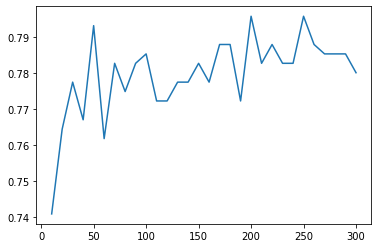

In [35]:
N = 30
accuracy = np.zeros(N)

for i in range(N):
    clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=(i+1)*10)
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    accuracy[i]=clf.score(X_test,y_test)

import matplotlib.pyplot as plt
plt.plot([10*(i+1) for i in range(30)], accuracy)
plt.show()

In [59]:
dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), max_features=0.5, max_samples=0.5, n_estimators=54).fit(X_train, y_train)
y_pred_bag_test = dt.predict(X_test)
y_pred_bag_train = dt.predict(X_train)

print(accuracy_score(y_train, y_pred_bag_train))
print(accuracy_score(y_test, y_pred_bag_test))
print("Even though the graph above shows possible accuracies of above 79%, experimenting with n_estimators did not get close to that.")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9615048118985127
0.7722513089005235
Even though the graph above shows possible accuracies of above 79%, experimenting with n_estimators did not get close to that.




## Model performance comparison

| Model | Train accuracy | Test accuracy |
|------|------|------|
| Random Forest  | 100% | 75% |
| Random Forest with upsampling | 100% | 74% |
| XGBoost | 100% | 79% |
| LightGBM | 98% | 77% |
| Gradient Boosting Classifier | 99% | 75% |
| AdaBoost | 98% | 78% |
| Decision Tree | 98% | 77% |
| Bagging | 87% | 76% |
| Extra Trees | 100% | 77% |